# Modeling TF-IDF + LogReg Notebook
**Baseline TF-IDF + Logistic Regression with basic and advanced preprocessed data**

This notebook provides:
1. Data loading & preprocessing (basic mode)
2. TF-IDF vectorization & logistic regression baseline on basic preprocessed data
3. Advanced preprocessing pipeline: Gensim phraser training, advanced cleaning, and full model replication on advanced preprocessed data

The model built on the basic-preprocessed data was developed sequentially—first incorporating cross-validation, then applying χ²-based feature selection, and finally integrating cost-sensitive learning—each enhancement yielding measurable performance gains. These stages serve as templates for subsequent model implementations, with parameters adapted as needed. 

**Model Development Progression:**
- **a) Absolute baseline**: Simple TF-IDF + LogReg with default parameters
- **b) Cross-validation baseline**: Added stratified CV, threshold optimization, and cost-sensitive learning
- **c) GridSearchCV approach**: Manual hyperparameter grid with feature selection
- **d) RandomizedSearchCV approach**: Scalable hyperparameter optimization for template use
- **e) Optuna TPE approach for HPO**: State-of-the-art intelligent hyperparameter optimization using Tree-structured Parzen Estimator

**Advanced Preprocessing Pipeline:**
- **Gensim Phraser training**: Multiword grouping model is trained on the corpus to detect frequent word combinations (e.g. 'soziale_gerechtigkeit')
- **Advanced cleaning**: Additional domain-specific noise removal, non-alphabetic filtering, stopword removal, and phrase-aware stemming
- **Model replication**: All modeling steps from the basic pipeline are repeated on the advanced preprocessed data for direct comparison

**Final Model Choice**: While GridSearchCV (section c) may achieve slightly better performance on this specific model and RandomizedSearchCV (section d) provides good scalability, we recommend the **Optuna TPE approach (section e)** for its superior intelligence in hyperparameter search, computational efficiency through early stopping, and state-of-the-art optimization methodology. This approach represents current best practices in ML research and scales optimally to complex model architectures in comparative studies.

--> **Use as a template**: Exchange model/embedding sections and hyperparameters as needed. The Optuna TPE structure provides the most robust and scalable template for any model architecture.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load, Memory
from scipy.stats import loguniform, randint

sys.path.append(os.path.abspath('..'))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna,
    sample_class_weight_value
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Data Loading & Initial Preprocessing


In [2]:
# Load and preprocess data (basic mode)
# labeling was performed on already basic cleaned segments 
# but we will clean it again, knowing that the segments might minimally change their structure
df_basiccleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

# Calculate token lengths for each segment
df_basiccleaned['SegmentTokenLength'] = df_basiccleaned['SegmentText'].str.split().str.len()

# Print overall statistics for token lengths
print("Overall SegmentTokenLength stats:\n", df_basiccleaned["SegmentTokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df_basiccleaned.groupby("Parliament")["SegmentTokenLength"].describe())
df_basiccleaned.head()

Overall SegmentTokenLength stats:
 count    1000.000000
mean      745.587000
std       320.475036
min        22.000000
25%       470.250000
50%       972.000000
75%      1000.000000
max      1000.000000
Name: SegmentTokenLength, dtype: float64

By Parliament:
             count        mean         std    min     25%     50%     75%  \
Parliament                                                                 
BB          216.0  820.898148  290.793284   39.0  708.50  1000.0  1000.0   
MV           85.0  797.976471  276.943865  148.0  640.00  1000.0  1000.0   
SA          268.0  804.011194  282.805481   43.0  608.75   994.5  1000.0   
SN          275.0  605.196364  353.491280   35.0  236.00   652.0  1000.0   
TH          156.0  759.878205  306.497915   22.0  493.50   966.5  1000.0   

               max  
Parliament          
BB          1000.0  
MV          1000.0  
SA          1000.0  
SN          1000.0  
TH          1000.0  


,DocumentID,SegmentID,Date,Parliament,Description,Links,Filter,SegmentText,Label,SegmentTokenLength
0,SA_100,SA_100_8,02.08.2023,SA,"Aktuelle Daten im PhÃ¤nomenbereich ""Politisch ...",[{'url': 'https://padoka.landtag.sachsen-anhal...,['wittenberg'],"24.11.2021 beimssiedlung 06:35 magdeburg, land...",0,1000
1,BB_189,BB_189_3,16.11.2023,BB,NaN,[{'url': 'https://www.parlamentsdokumentation....,['leag'],im vorfeld der parlamentarischen konferenz mit...,0,134
2,SA_232,SA_232_1,17.11.2023,SA,Ausschussprotokoll Ausschuss fÃ¼r Finanzen 8/F...,[{'url': 'https://padoka.landtag.sachsen-anhal...,"['wasserstoff', 'kraftwerke', 'wärmeplanung', ...",einladung: einladung 8/fin/52 ausschuss für fi...,0,1000
3,SA_140,SA_140_1,29.08.2023,SA,Gewaltschutz und Hilfssysteme im Sinne der Ist...,[{'url': 'https://padoka.landtag.sachsen-anhal...,['lauchstädt'],dokument: drucksache 8/3052 öffentlich antrag ...,0,707
4,SA_372,SA_372_1,14.03.2024,SA,Ausschussprotokoll Ausschuss fÃ¼r Petitionen 8...,[{'url': 'https://padoka.landtag.sachsen-anhal...,['wittenberg'],einladung: einladung 8/pet/39 öffentlich aussc...,0,439


## 2) Baseline: TF-IDF + Logistic Regression
Standard train/test split, threshold = 0.5.

In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

**a) absolute baseline**

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       146
           1       1.00      0.20      0.34        54

    accuracy                           0.79       200
   macro avg       0.89      0.60      0.61       200
weighted avg       0.83      0.79      0.73       200

Additional Metrics:
Accuracy   0.785
F2-score   0.242
AUC-ROC    0.841
AUC-PR     0.741



Text(0.5, 1.0, 'Metric Scores vs Classification Threshold')

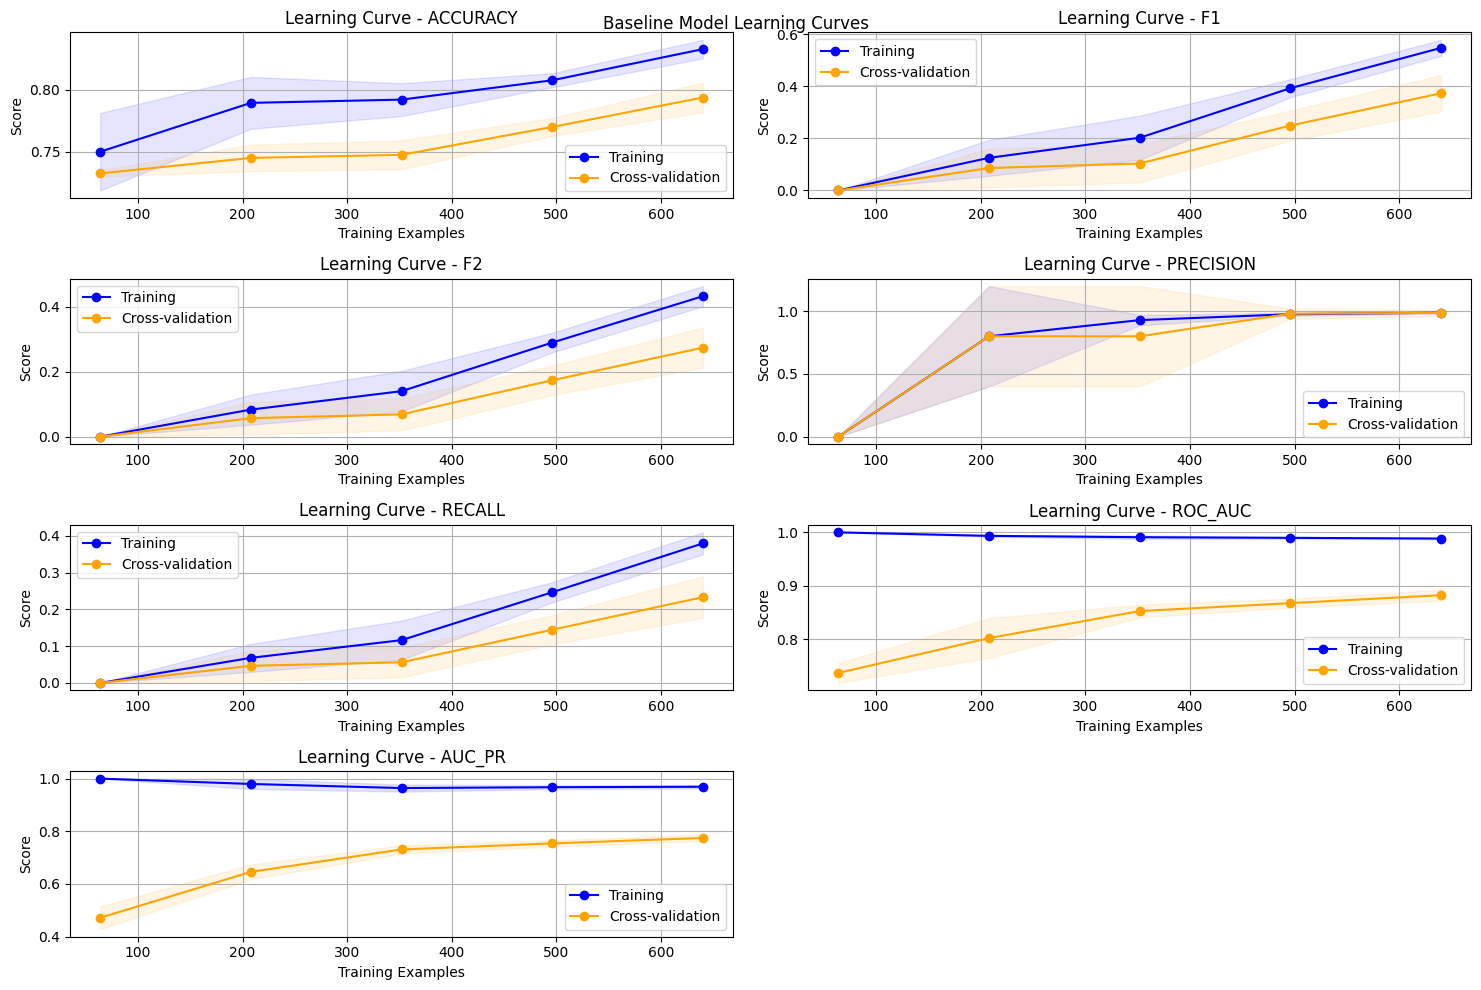

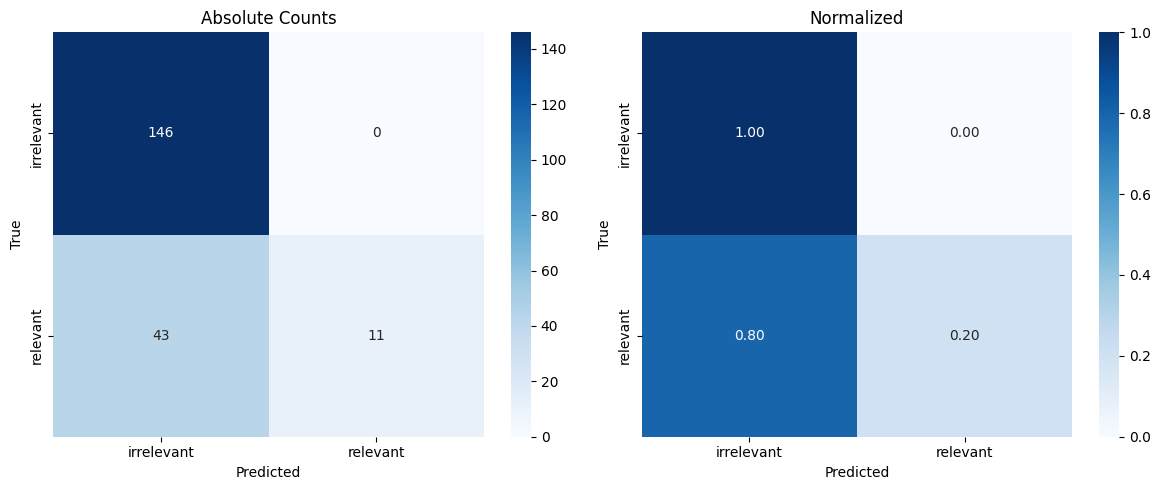

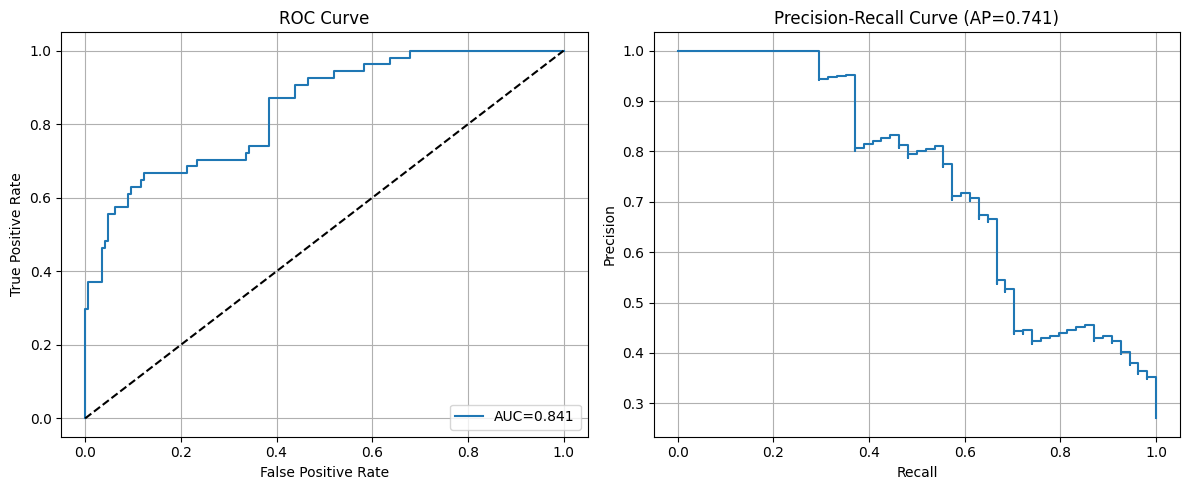

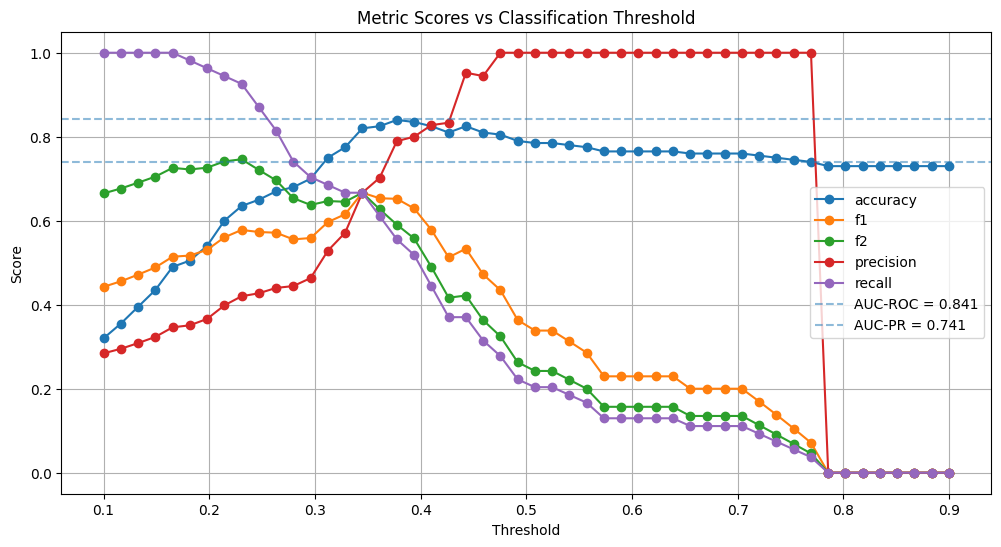

In [4]:
#define baseline model pipeline
pipeline_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LogisticRegression(solver="liblinear", random_state=42))
])

# Fit baseline and get predictions
pipeline_baseline.fit(X_dev, y_dev)
y_pred = pipeline_baseline.predict(X_test)
y_pred_proba = pipeline_baseline.predict_proba(X_test)

# Basic evaluation on our metrics
print("Baseline Model Performance:")
print(extended_classification_report(y_test, y_pred, y_pred_proba[:, 1]))

# Evaluation
# Learning Curves (Multi-Metric Analysis)
# Using all metrics including F2, ROC-AUC, and AUC-PR
plot_learning_curves(pipeline_baseline, X_dev, y_dev, 
                    cv=5,
                    figsize=(15, 10))
plt.suptitle('Baseline Model Learning Curves')

# Confusion Matrix (Absolute and Normalized)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()

# ROC and Precision-Recall Analysis

plot_roc_and_pr_curves(y_test, y_pred_proba[:, 1])

# Threshold Analysis and Visualization (baseline)
import types
dummy = types.SimpleNamespace(estimator_=pipeline_baseline) # Create a dummy object to mimic the tuned estimator interface
thresholds = np.linspace(0.1, 0.9, 50)
threshold_data = get_threshold_evaluation_data(
    tuned_estimator=dummy,
    X=X_test,
    y=y_test,
    thresholds=thresholds
)
plot_threshold_curves(threshold_data)
plt.title('Metric Scores vs Classification Threshold')

**b) baseline with stratified cross validation and threshold optimization**
- during development we recognised the necessity to perform a threshold optimization because of data imbalance and the importance of recall over precision. 
- we use sklearn's `TunedThresholdClassifierCV` method with a **coarse-to-fine optimization strategy** (zou et al., reusens et al.): 
  - **Stage 1 (coarse)**: Evaluate 50 threshold candidates across the full score range to identify the optimal region
  - **Stage 2 (fine)**: Evaluate another 50 candidates within ±15% of the best coarse threshold for precise optimization
- this two-stage approach ensures robust threshold selection across different model types (LogReg probabilities vs SVM decision functions)
- final model and optimized threshold are used on the test_data

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 100}}
Best F2 score during CV: 0.802

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 100}}
Best F2 score during CV: 0.802

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.147
CV F2-score with optimized threshold: 0.822

Generating unbiased threshold visualization...
Optimized threshold: 0.147
CV F2-score with optimized threshold: 0.822

Generating unbiased threshold visualization...


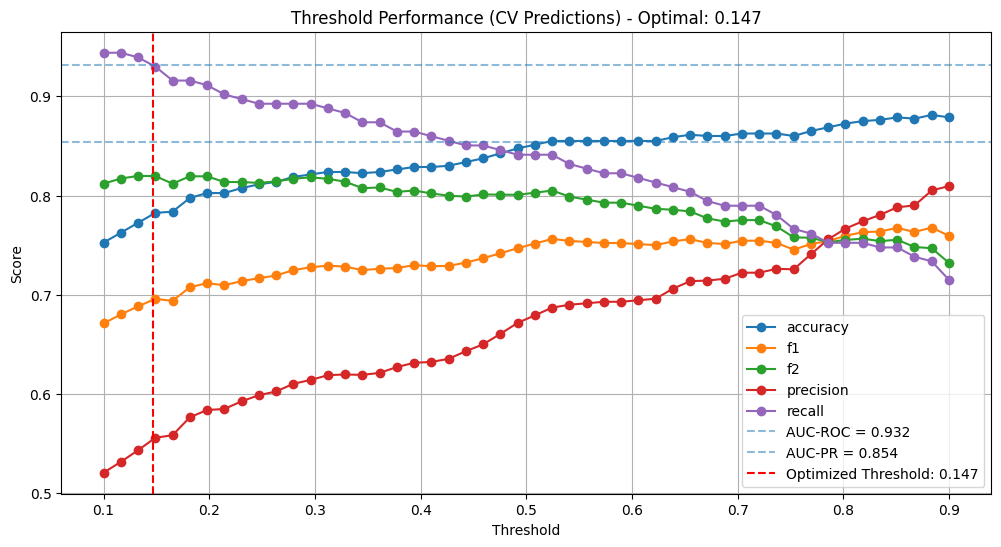

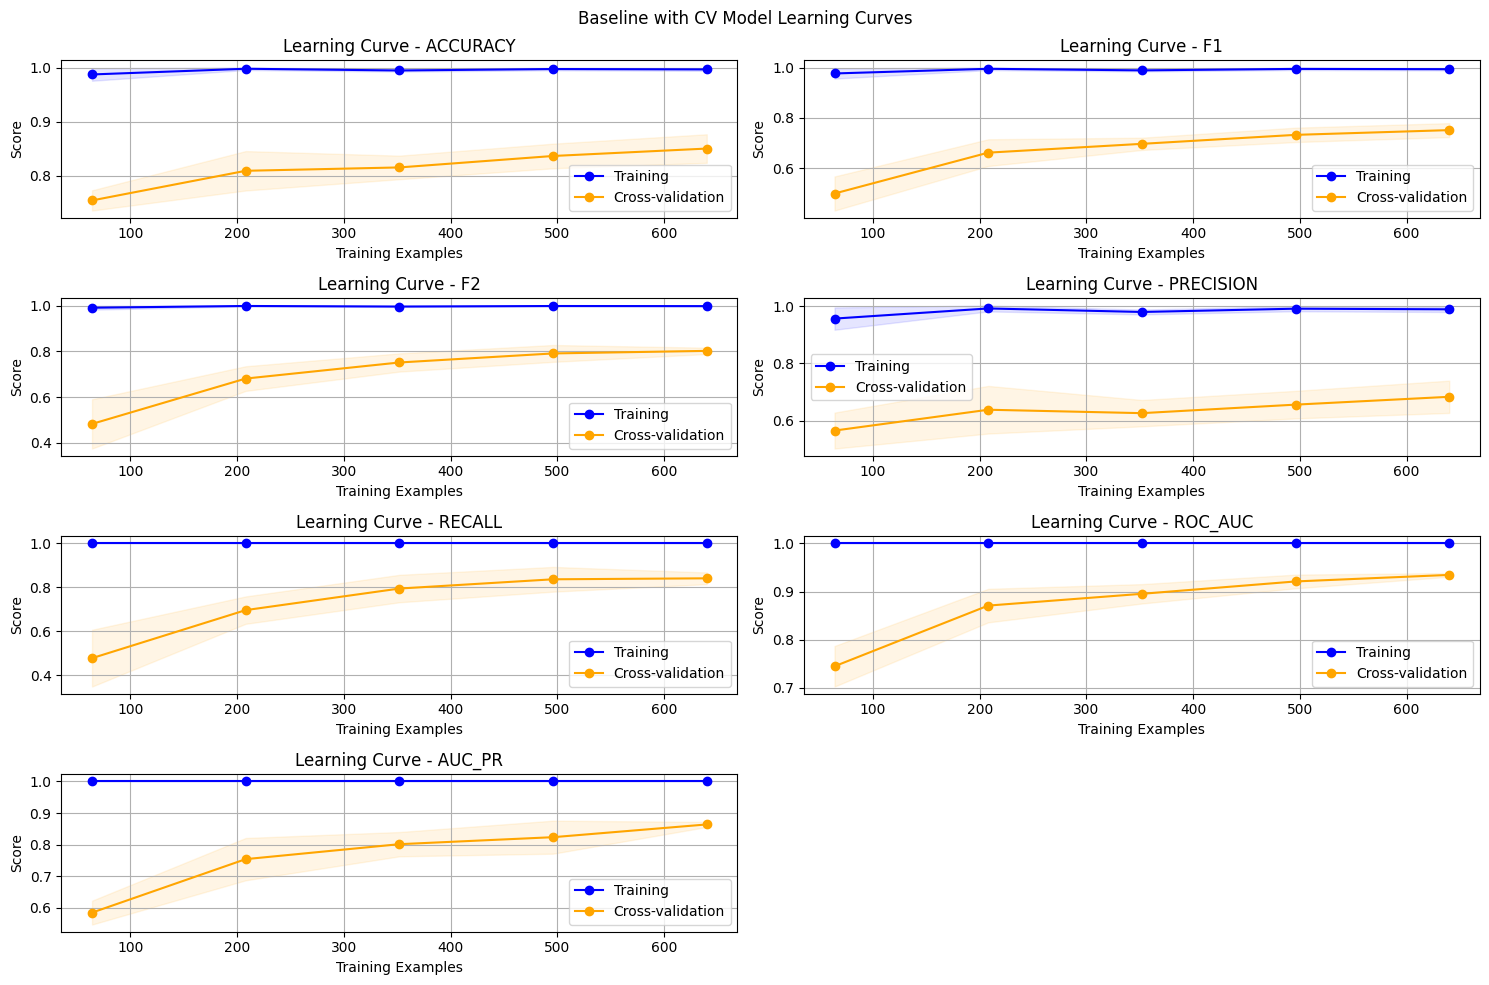


Final Evaluation on Test Set:

Final Threshold: 0.15

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.66      0.78       146
           1       0.49      0.87      0.63        54

    accuracy                           0.72       200
   macro avg       0.71      0.77      0.70       200
weighted avg       0.81      0.72      0.74       200

Additional Metrics:
Accuracy   0.720
F2-score   0.753
AUC-ROC    0.870
AUC-PR     0.749



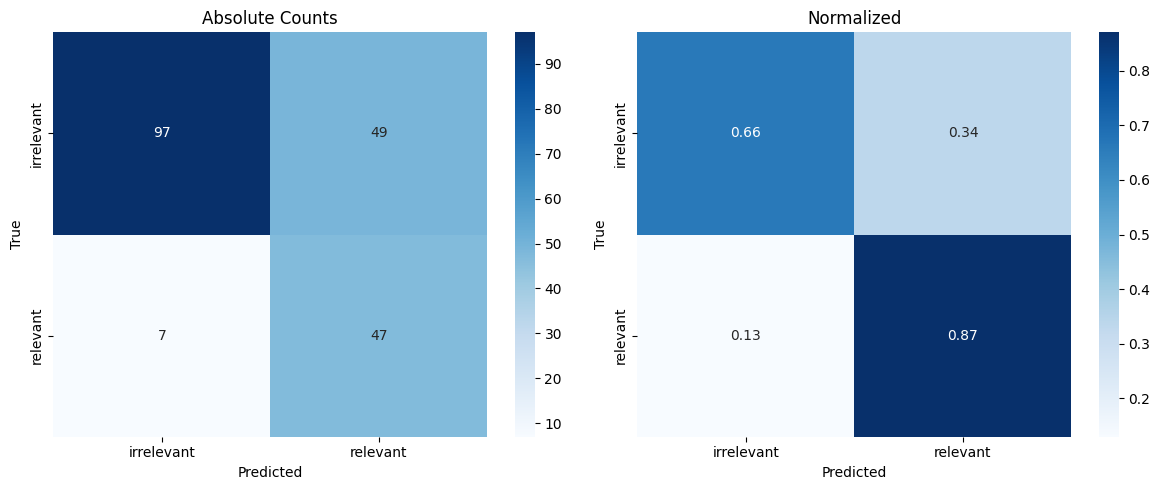

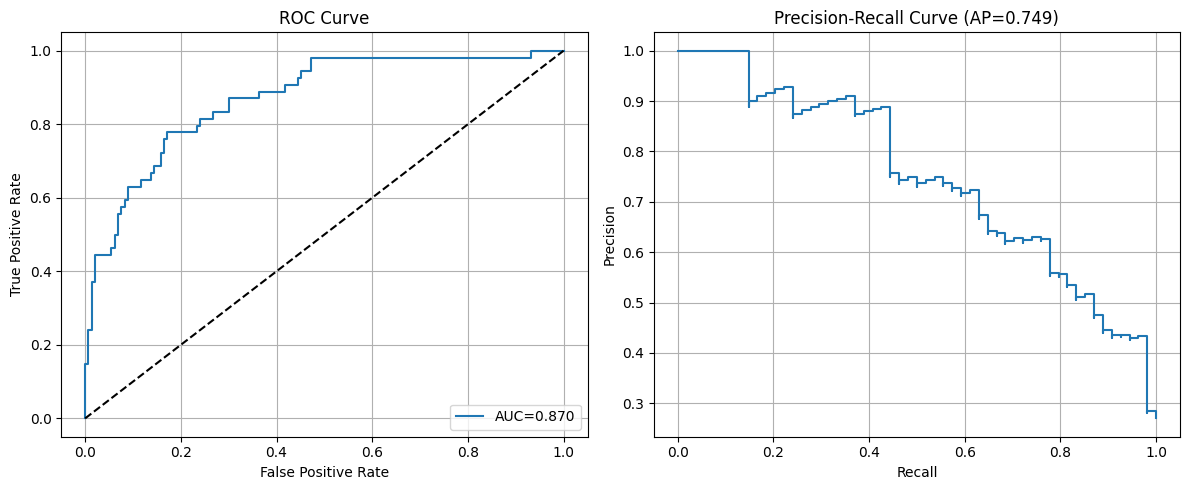

In [5]:
# Define a Pipeline for training via cross-validation with lasso regularization and class_weight
pipeline_cv_baseline = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf",  LogisticRegression(solver="liblinear", penalty="l1", class_weight="balanced", random_state=42))
])

# penalty parameter grid for cross-validation
param_grid_cv_baseline = {
    "clf__C": [0.01, 0.1, 1, 10, 25, 50], 
    "clf__class_weight": ["balanced",  {0:1, 1:90}, {0:1, 1:100}, {0:1, 1:110}]
}

# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_cv_baseline = GridSearchCV(
    pipeline_cv_baseline,
    param_grid_cv_baseline,
    cv=cv,
    scoring=f2_scorer,  # using custom F2 scorer
    n_jobs=-1,
    verbose=1
)

# Fit cv_baseline and get predictions
grid_cv_baseline.fit(X_dev, y_dev)

# Get best parameters and score
print("Best parameters:", grid_cv_baseline.best_params_)
print(f"Best F2 score during CV: {grid_cv_baseline.best_score_:.3f}")

# Get the best model from the grid search
model_cv_baseline = grid_cv_baseline.best_estimator_

#  Proper threshold optimization with nested CV and coarse-to-fine strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_cv_baseline, threshold_results = optimize_threshold_with_cv(
    base_estimator=model_cv_baseline,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same 5-fold CV strategy for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using cross-validation predict
# This shows how different thresholds perform on out-of-fold predictions (realistic view)
print("\nGenerating unbiased threshold visualization...")

threshold_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=model_cv_baseline,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same 5-fold CV for visualization consistency
)

plot_threshold_curves(threshold_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning Curves Analysis
plot_learning_curves(model_cv_baseline, X_dev, y_dev, 
                    cv=cv,
                    figsize=(15, 10))
plt.suptitle('Baseline with CV Model Learning Curves')
plt.tight_layout()
plt.show()

print("\nFinal Evaluation on Test Set:")

# Get predictions on test set using the tuned model
y_test_pred = tuned_cv_baseline.predict(X_test)  # Uses optimized threshold
y_test_proba = tuned_cv_baseline.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

# Final visualizations on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall Analysis (only for final evaluation)
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

**c) model TF-IDF LogReg with basic preprocessed data using GridSearch**
- we build on findings from b) and try to minimize noise/overfitting/large penalty terms
- we do that by implementing an filtering method (chi-squared-filtering) to only keep most relevant vectors for our prediction
- implement the filter into our grid-search

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 15}, 'select__k': 100}
Best F2 score during CV: 0.847

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Best parameters: {'clf__C': 10, 'clf__class_weight': {0: 1, 1: 15}, 'select__k': 100}
Best F2 score during CV: 0.847

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.518
CV F2-score with optimized threshold: 0.847

Generating unbiased threshold visualization...
Optimized threshold: 0.518
CV F2-score with optimized threshold: 0.847

Generating unbiased threshold visualization...


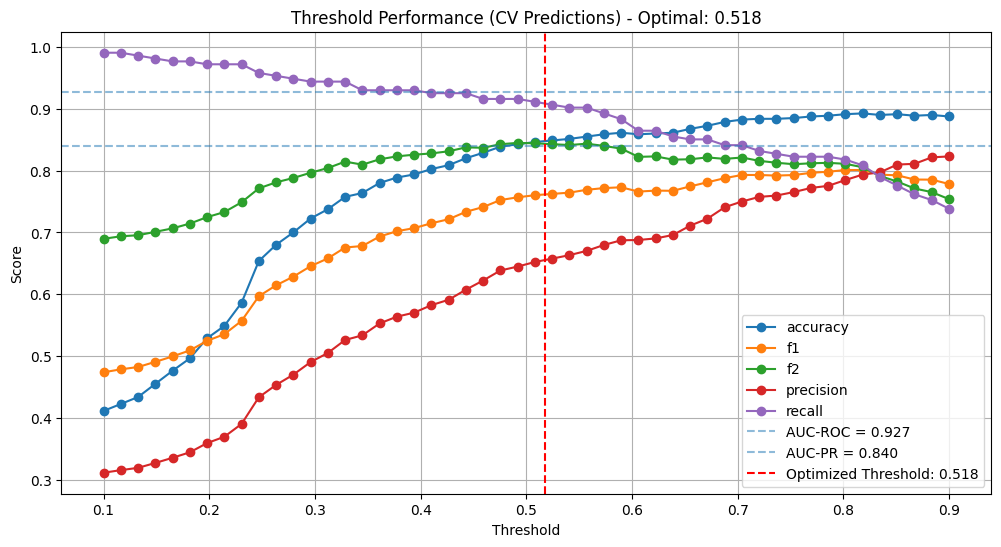

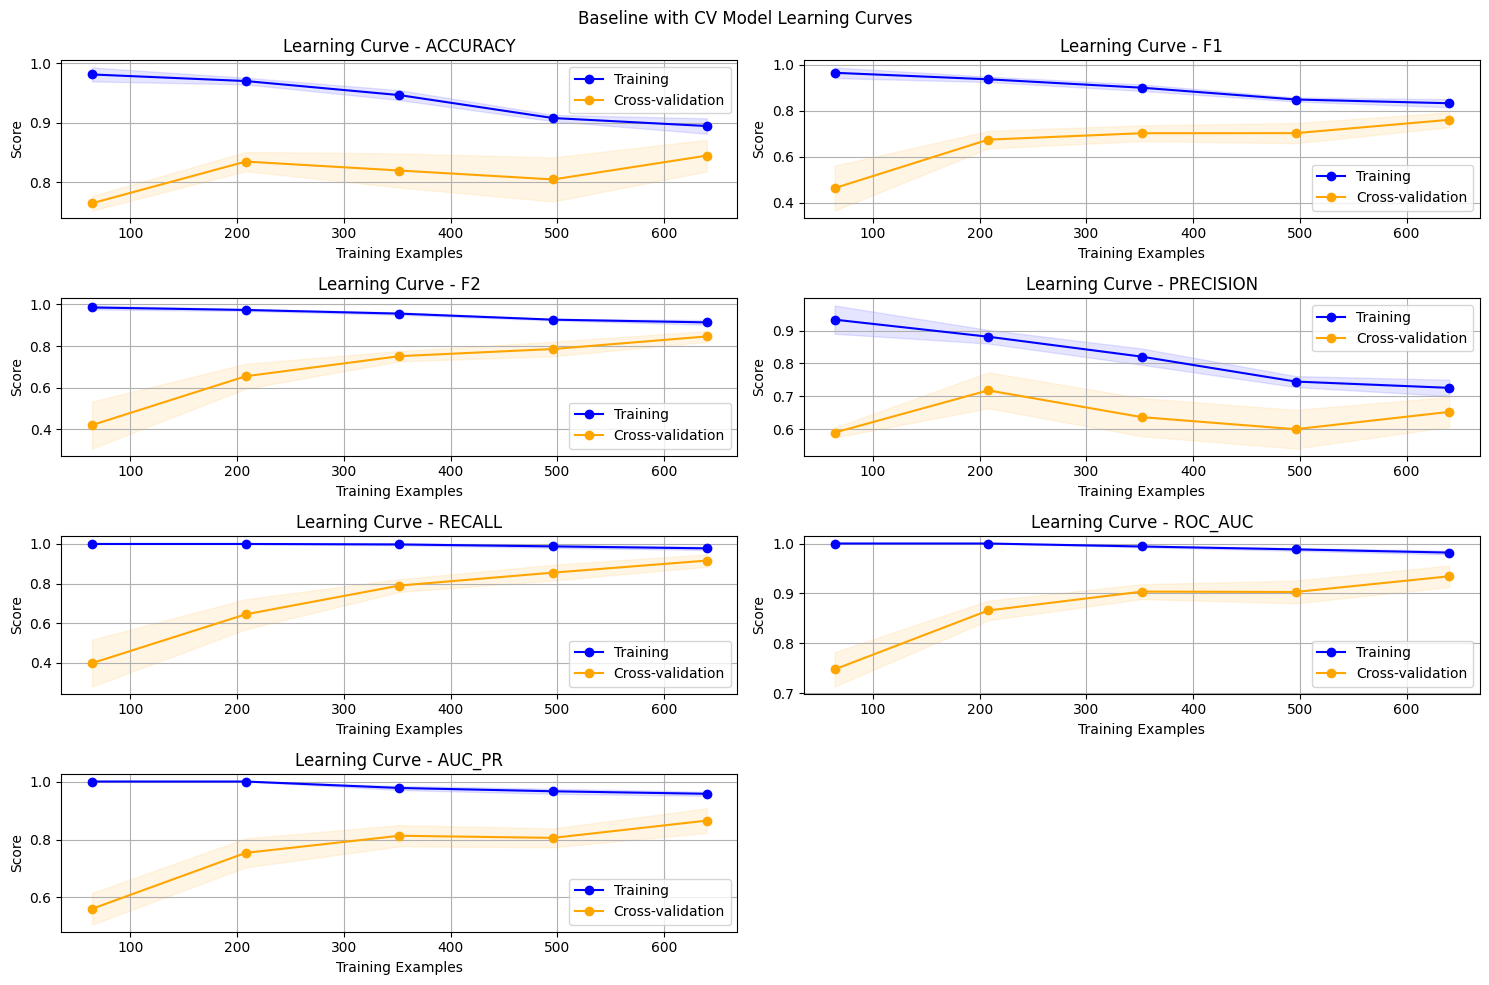


Final Evaluation on Test Set:

Final Threshold: 0.52

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       146
           1       0.67      0.87      0.76        54

    accuracy                           0.85       200
   macro avg       0.81      0.86      0.82       200
weighted avg       0.87      0.85      0.86       200

Additional Metrics:
Accuracy   0.850
F2-score   0.822
AUC-ROC    0.917
AUC-PR     0.822



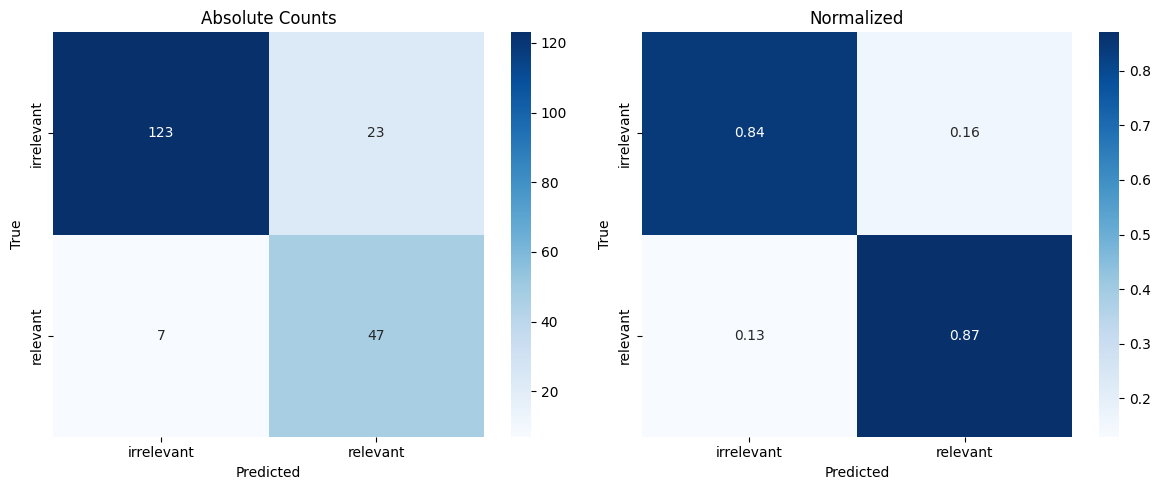

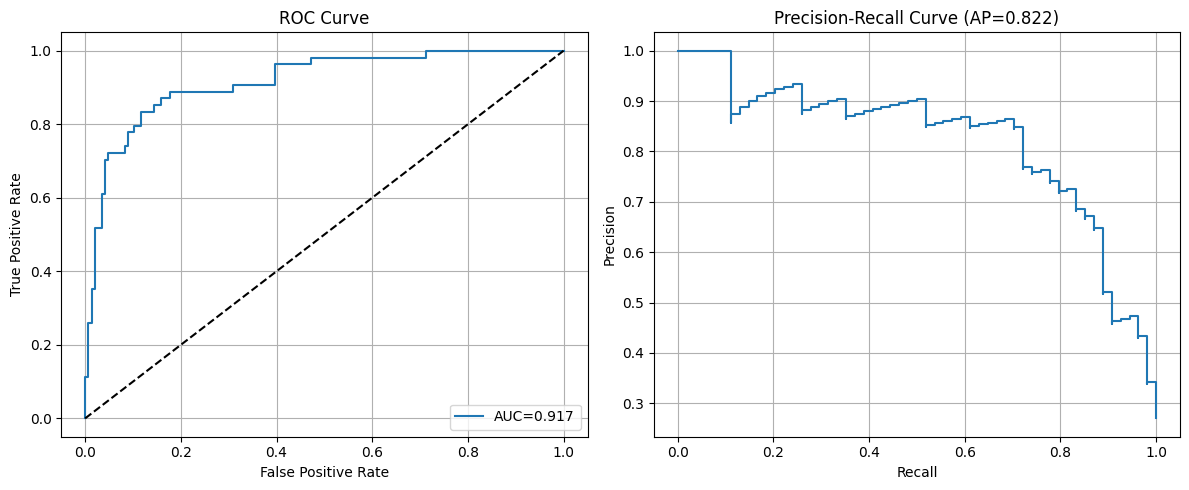

In [6]:
# Define a Pipeline for tfidf vectorization, lasso regularization, class_weight for cost-sensitive learning, and feature selection via chi2
pipeline_tfidf_logreg = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("select", SelectKBest(score_func=chi2, k=2000)),
    ("clf",  LogisticRegression(solver="liblinear", penalty="l1", class_weight="balanced", random_state=42))
])

# penalty parameter grid for cross-validation
param_grid_tfidf_logreg = {
    "clf__C": [1, 10, 20],
    "select__k": [50, 100, 150], 
    "clf__class_weight": ["balanced",  {0:1, 1:5}, {0:1, 1:15}, {0:1, 1:20}]
}

# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_cv_baseline = GridSearchCV(
    pipeline_tfidf_logreg,
    param_grid_tfidf_logreg,
    cv=cv,
    scoring=f2_scorer,  # using custom F2 scorer
    n_jobs=-1,
    verbose=1
)

# Fit cv_baseline and get predictions
grid_cv_baseline.fit(X_dev, y_dev)

# Get best parameters and score
print("Best parameters:", grid_cv_baseline.best_params_)
print(f"Best F2 score during CV: {grid_cv_baseline.best_score_:.3f}")

# Get the best model from the grid search
model_cv_baseline = grid_cv_baseline.best_estimator_

# MODERN: Proper threshold optimization with nested CV and coarse-to-fine strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_cv_baseline, threshold_results = optimize_threshold_with_cv(
    base_estimator=model_cv_baseline,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same 5-fold CV strategy for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using cross-validation predict
# This shows how different thresholds perform on out-of-fold predictions (realistic view)
print("\nGenerating unbiased threshold visualization...")

threshold_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=model_cv_baseline,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same 5-fold CV for visualization consistency
)

plot_threshold_curves(threshold_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning Curves Analysis
plot_learning_curves(model_cv_baseline, X_dev, y_dev, 
                    cv=cv,
                    figsize=(15, 10))
plt.suptitle('Baseline with CV Model Learning Curves')
plt.tight_layout()
plt.show()

print("\nFinal Evaluation on Test Set:")

# Get predictions on test set using the tuned model
y_test_pred = tuned_cv_baseline.predict(X_test)  # Uses optimized threshold
y_test_proba = tuned_cv_baseline.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

# Final visualizations on test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, 
                     title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True, ax=ax2,
                     title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall Analysis (only for final evaluation)
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

**d) model with randomizedsearchcv instead of gridsearch**

Why RandomizedSearchCV over GridSearchCV?

While GridSearchCV (section c) might achieve slightly better performance on this specific TF-IDF + LogReg combination, we implement RandomizedSearchCV here for several strategic reasons:

1. Template Scalability: This approach can be easily adapted to any model type (neural networks, SVMs, ensemble methods) without manually crafting parameter grids for each model
2. Hyperparameter Space Exploration: Continuous distributions (like loguniform) explore a much larger parameter space than discrete grids, potentially finding better configurations
3. Computational Efficiency: For complex models with many hyperparameters, RandomizedSearch scales better than exhaustive grid search
4. Consistent Methodology: Using the same hyperparameter optimization approach across all models ensures fair comparison
5. Trade-off Justification: We accept potentially slightly lower performance on this specific model to gain significant advantages in methodology consistency, scalability, and reproducibility across our entire model comparison framework. This approach aligns with best practices for systematic model evaluation in academic research.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'clf__C': 6.220638781359818, 'clf__class_weight': {0: 1, 1: 9}, 'select__k': 135}
Best F2 score during CV: 0.821

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Best parameters: {'clf__C': 6.220638781359818, 'clf__class_weight': {0: 1, 1: 9}, 'select__k': 135}
Best F2 score during CV: 0.821

Optimizing threshold with nested cross-validation (coarse-to-fine)...
Optimized threshold: 0.399
CV F2-score with optimized threshold: 0.830

Generating unbiased threshold visualization...
Optimized threshold: 0.399
CV F2-score with optimized threshold: 0.830

Generating unbiased threshold visualization...


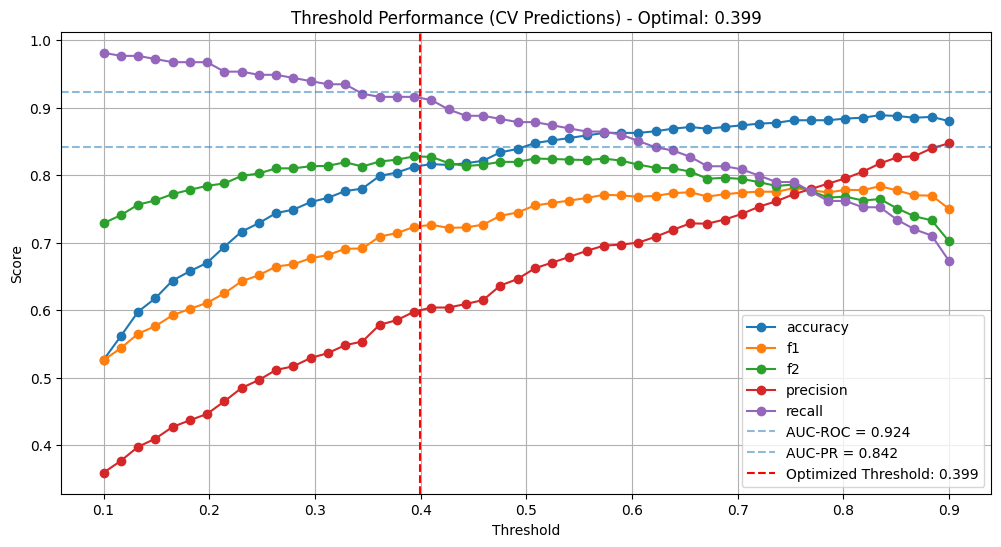

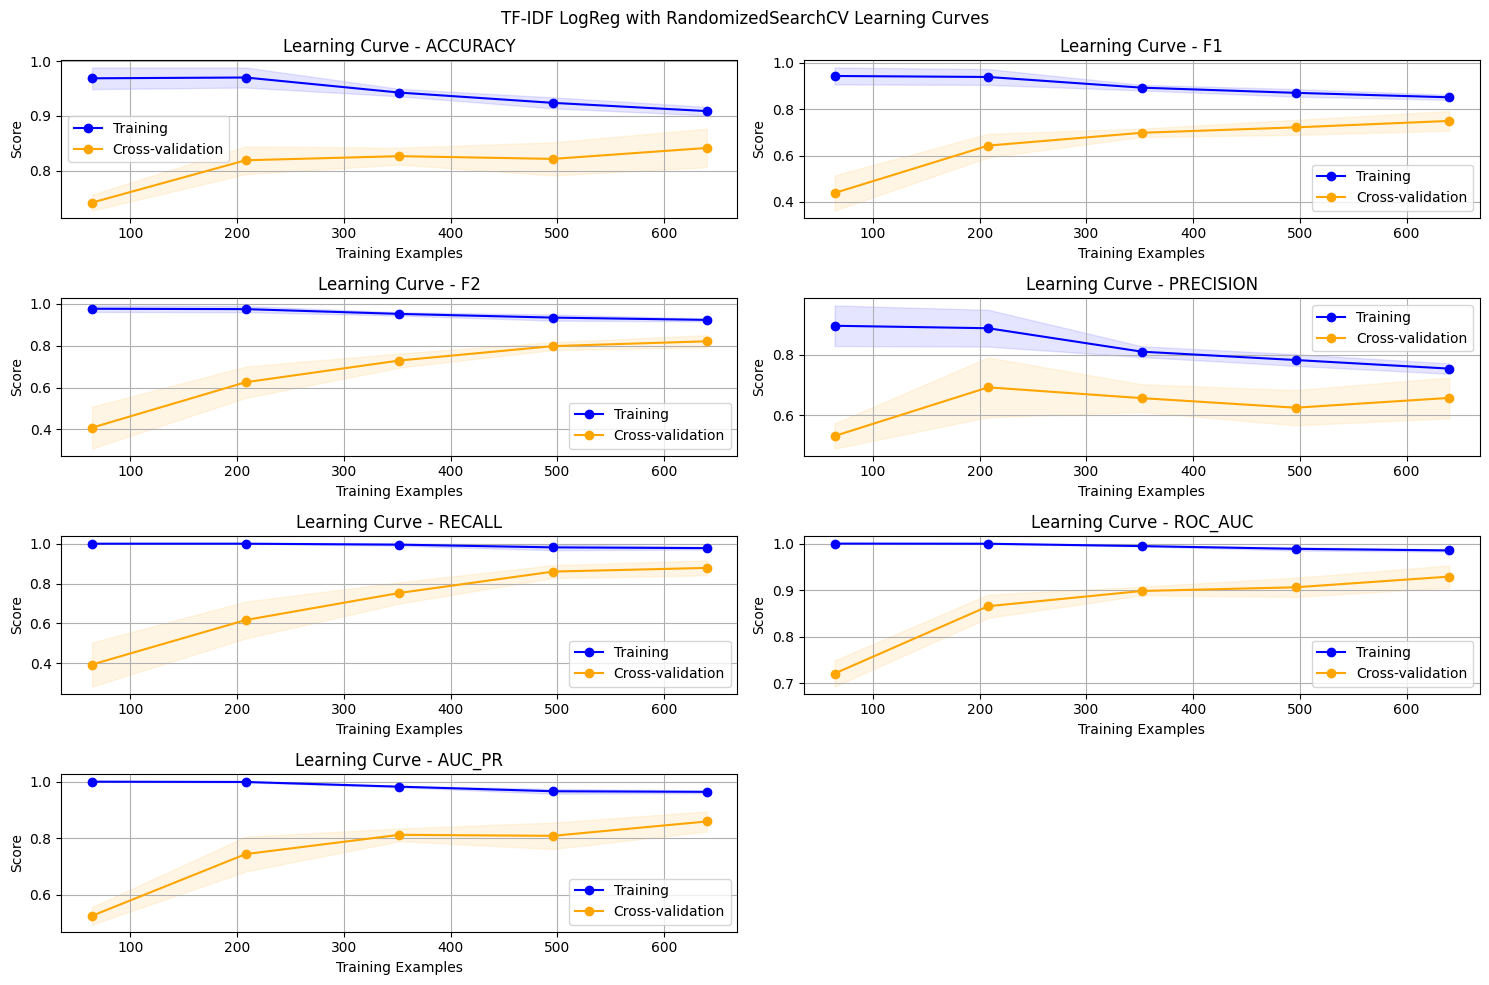


Final Threshold: 0.40

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       146
           1       0.62      0.85      0.72        54

    accuracy                           0.82       200
   macro avg       0.78      0.83      0.79       200
weighted avg       0.85      0.82      0.83       200

Additional Metrics:
Accuracy   0.820
F2-score   0.793
AUC-ROC    0.896
AUC-PR     0.787



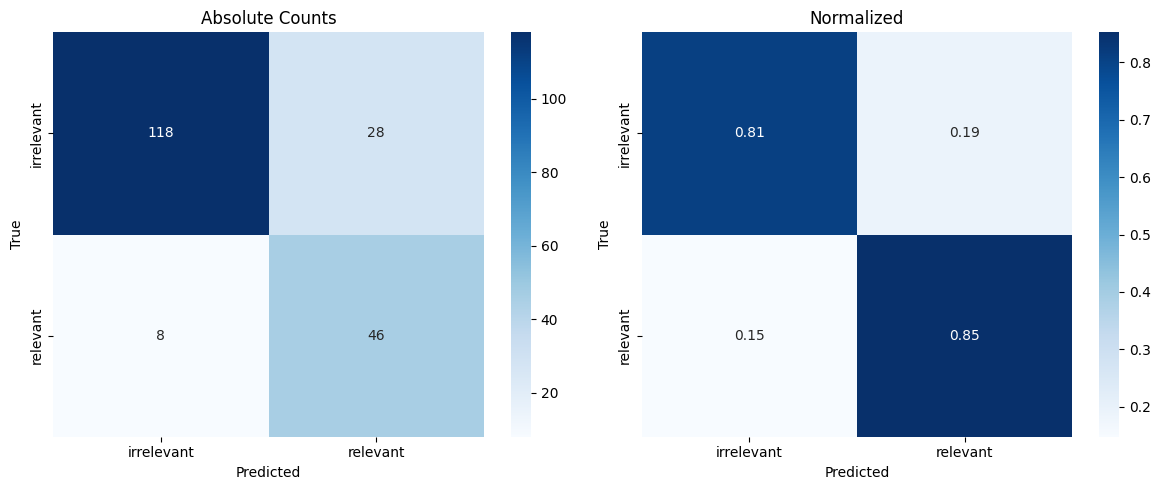

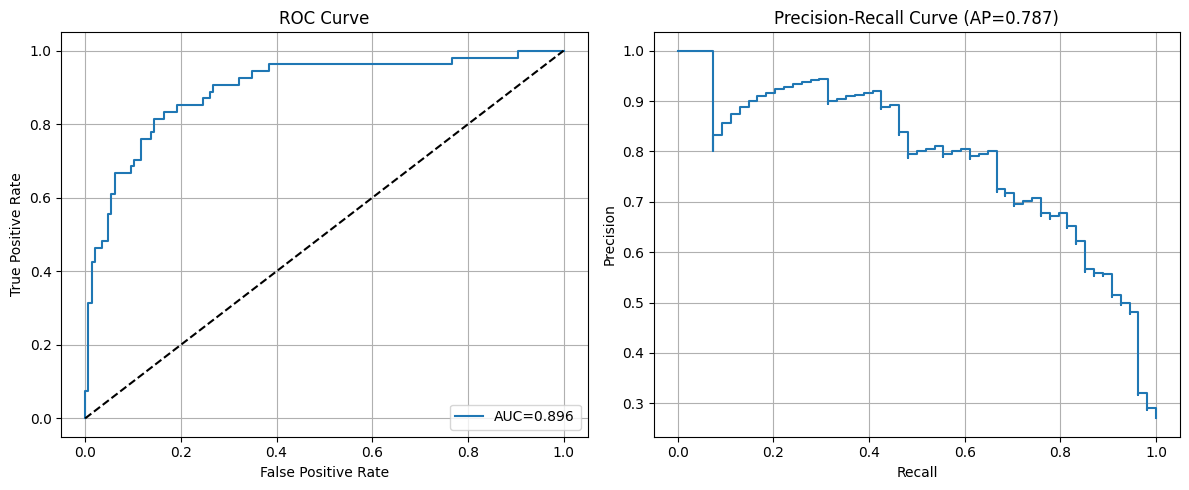

In [7]:
# Base Pipeline 
pipeline_tfidf_logreg = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LogisticRegression(
                    solver="liblinear",
                    penalty="l1",
                    class_weight="balanced",
                    random_state=42
                ))
])

# Hyperparameter Distributions for Random Search
# This approach scales better to different model types
weights = ["balanced"] + [{0:1, 1:w} for w in range(1, 31, 2)]
param_dist_tfidf_logreg = {
    "clf__C":            loguniform(1e-3, 1e3),      # C ∈ [1e-3, 1e3]
    "select__k":         randint(50, 151),           # k ∈ {50, …, 150}
    "clf__class_weight": weights  # class weights for cost-sensitive learning
}

# F2 Scorer and CV Strategy
f2_scorer = make_scorer(fbeta_score, beta=2)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV (100 random configurations)
# Advantage: Easily adaptable to different models without manual grid tuning
rand_search = RandomizedSearchCV(
    estimator         = pipeline_tfidf_logreg,
    param_distributions = param_dist_tfidf_logreg,
    n_iter            = 100,
    cv                = cv,
    scoring           = f2_scorer,
    n_jobs            = -1,
    random_state      = 42,
    verbose           = 1,
    return_train_score=True
)

# Execute search
rand_search.fit(X_dev, y_dev)
print("Best parameters:", rand_search.best_params_)
print(f"Best F2 score during CV: {rand_search.best_score_:.3f}")

# Extract best model
base_model = rand_search.best_estimator_

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LogReg with RandomizedSearchCV Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
print(extended_classification_report(y_test, y_test_pred, y_test_proba))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Save the properly tuned model
#dump({
#   'model': tuned_model,  # This includes the optimized threshold
#   'base_model': base_model,  # Original model without threshold optimization
#    'threshold': threshold_results['best_threshold'],
#    'cv_score': threshold_results['cv_score'],
#    'best_params': rand_search.best_params_,
#    'search_type': 'RandomizedSearchCV + TunedThresholdClassifierCV'
#}, "model_tfidf_logreg_basic.joblib")

#print(f"\nModel saved as 'model_tfidf_logreg_basic.joblib'")


**e) Advanced Hyperparameter Optimization with Optuna**

**Why Optuna over RandomizedSearchCV/GridSearchCV?**

While RandomizedSearchCV (section d) provides good scalability and GridSearchCV (section c) offers exhaustive search within defined grids, we implement Optuna here for several advanced optimization reasons:

1. **Intelligent Search Strategy**: Optuna uses Tree-structured Parzen Estimator (TPE) algorithm that learns from previous trials to suggest better hyperparameter combinations, unlike random sampling
2. **Dynamic Search Space**: Can handle conditional hyperparameters and complex search spaces more elegantly than static distributions
3. **Early Stopping & Pruning**: Automatically terminates unpromising trials early, saving computational resources significantly
4. **Advanced Sampling**: TPE is more efficient than random sampling, especially for high-dimensional hyperparameter spaces
5. **State-of-the-art HPO**: Represents current best practices in hyperparameter optimization research
6. **Visualization & Analysis**: Built-in tools for hyperparameter importance analysis and optimization history

**Scientific Justification**: Optuna's TPE algorithm has been shown to converge faster to optimal hyperparameters compared to random search, especially important for complex models with many hyperparameters. This approach aligns with cutting-edge ML research practices.

**Template Advantage**: While this specific TF-IDF + LogReg model may not fully showcase Optuna's advantages, this implementation serves as a robust template for more complex models (neural networks, ensemble methods) where intelligent hyperparameter search becomes critical.

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 11.110321714231238, 'select__k': 101, 'positive_class_weight': 18}
Best F2 score during optimization: 0.842

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


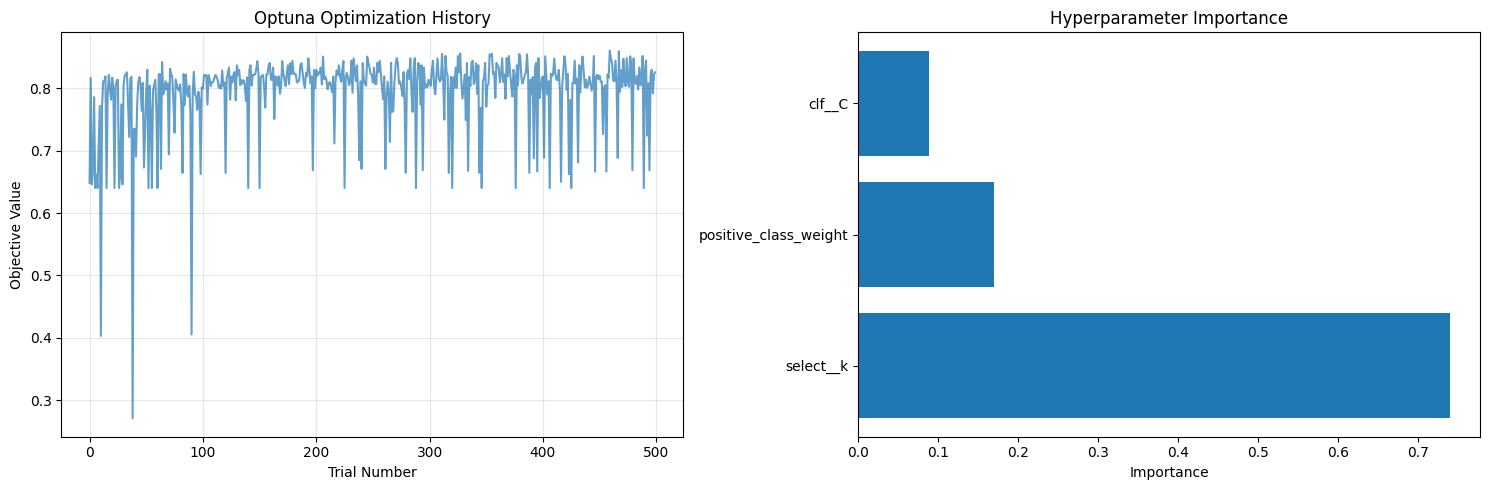


2. Parameter Value Distributions:


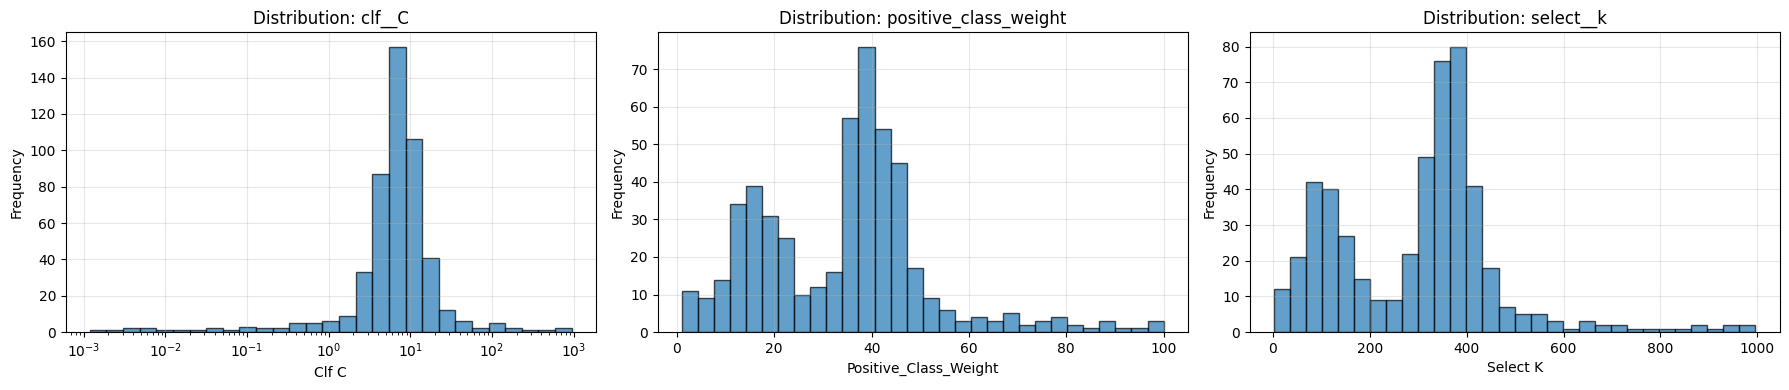


3. Performance vs Individual Parameters:


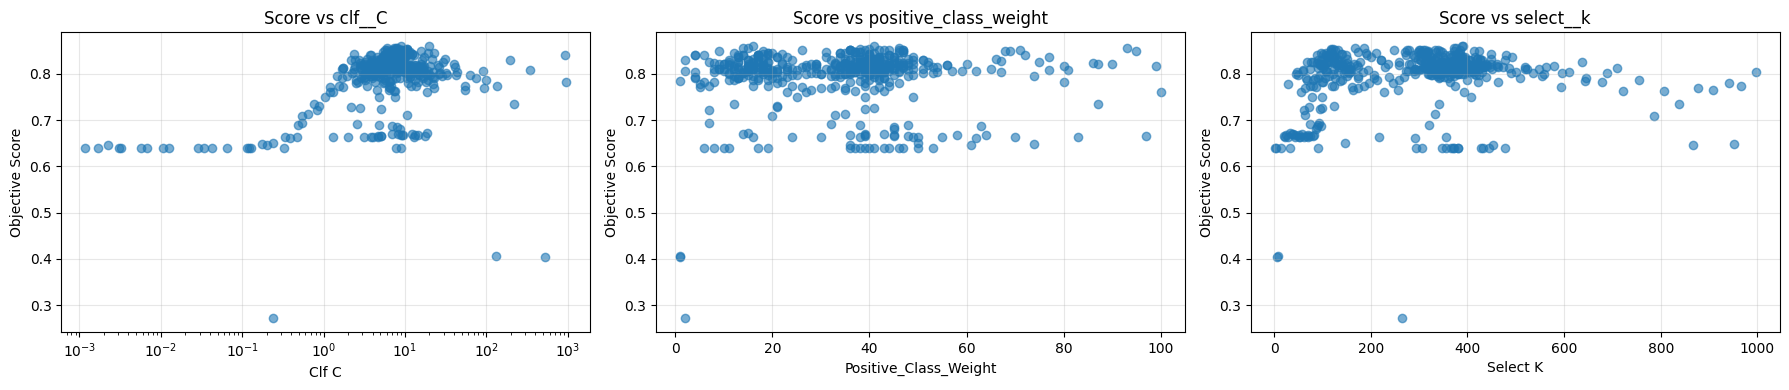


4. Convergence Analysis:


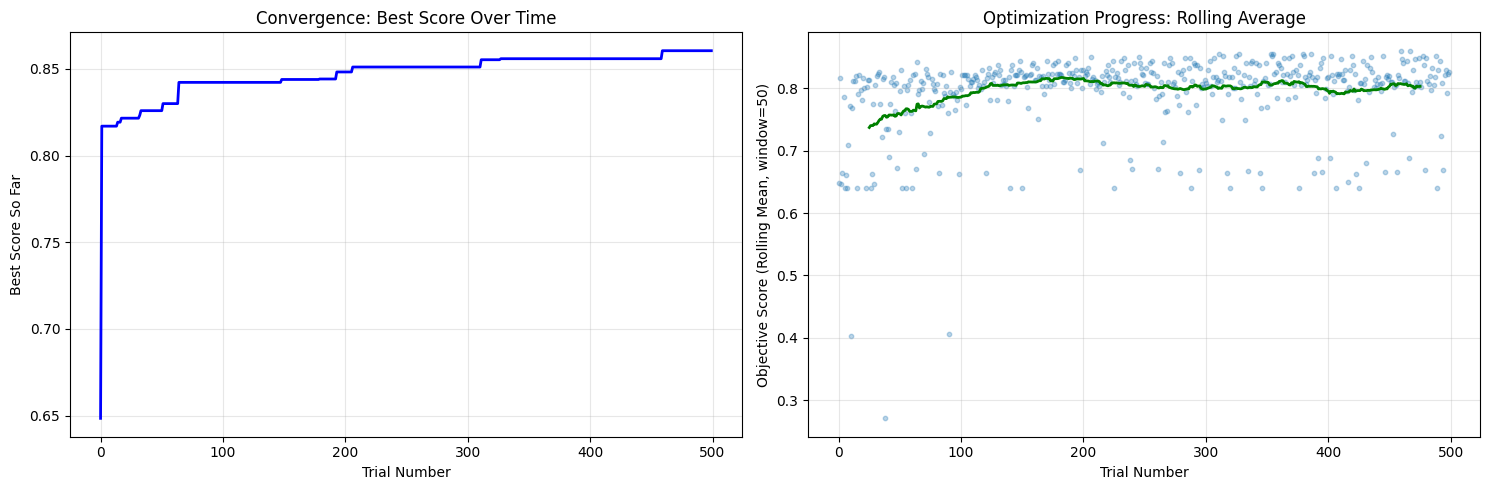


5. Trial Status Overview:


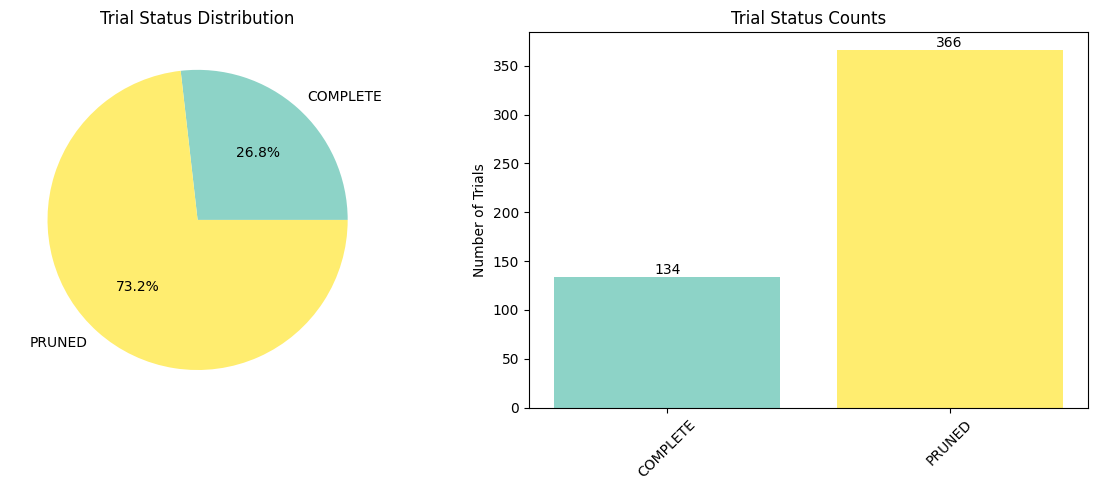


6. Top 10 Best Trials:
Rank Trial#  Score      C            positive_class_weight k           
-----------------------------------------------------------------------
1    459     0.8605     19.5283      16           388         
2    467     0.8597     9.0002       41           391         
3    327     0.8559     7.4005       46           377         
4    355     0.8559     8.0537       15           187         
5    311     0.8553     7.8029       14           167         
6    379     0.8553     6.0063       93           373         
7    353     0.8547     10.7103      40           121         
8    386     0.8547     10.4943      38           117         
9    314     0.8520     8.8786       42           276         
10   325     0.8520     9.6521       36           308         

7. Study Statistics Summary:
• Total trials: 500
• Successful trials: 500
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #64
• Best objective value: 0.8422
• Score statistics:
  - Mean: 0.7947

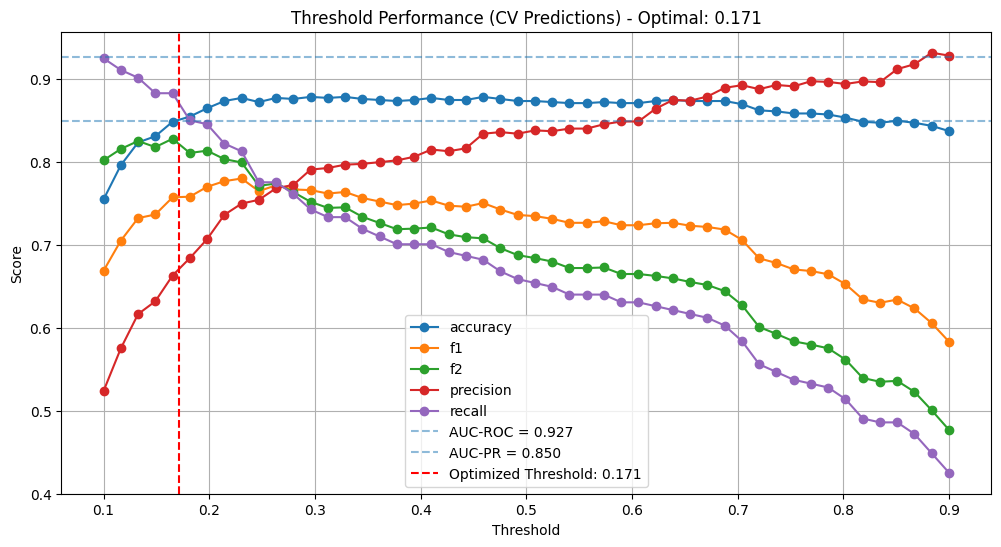

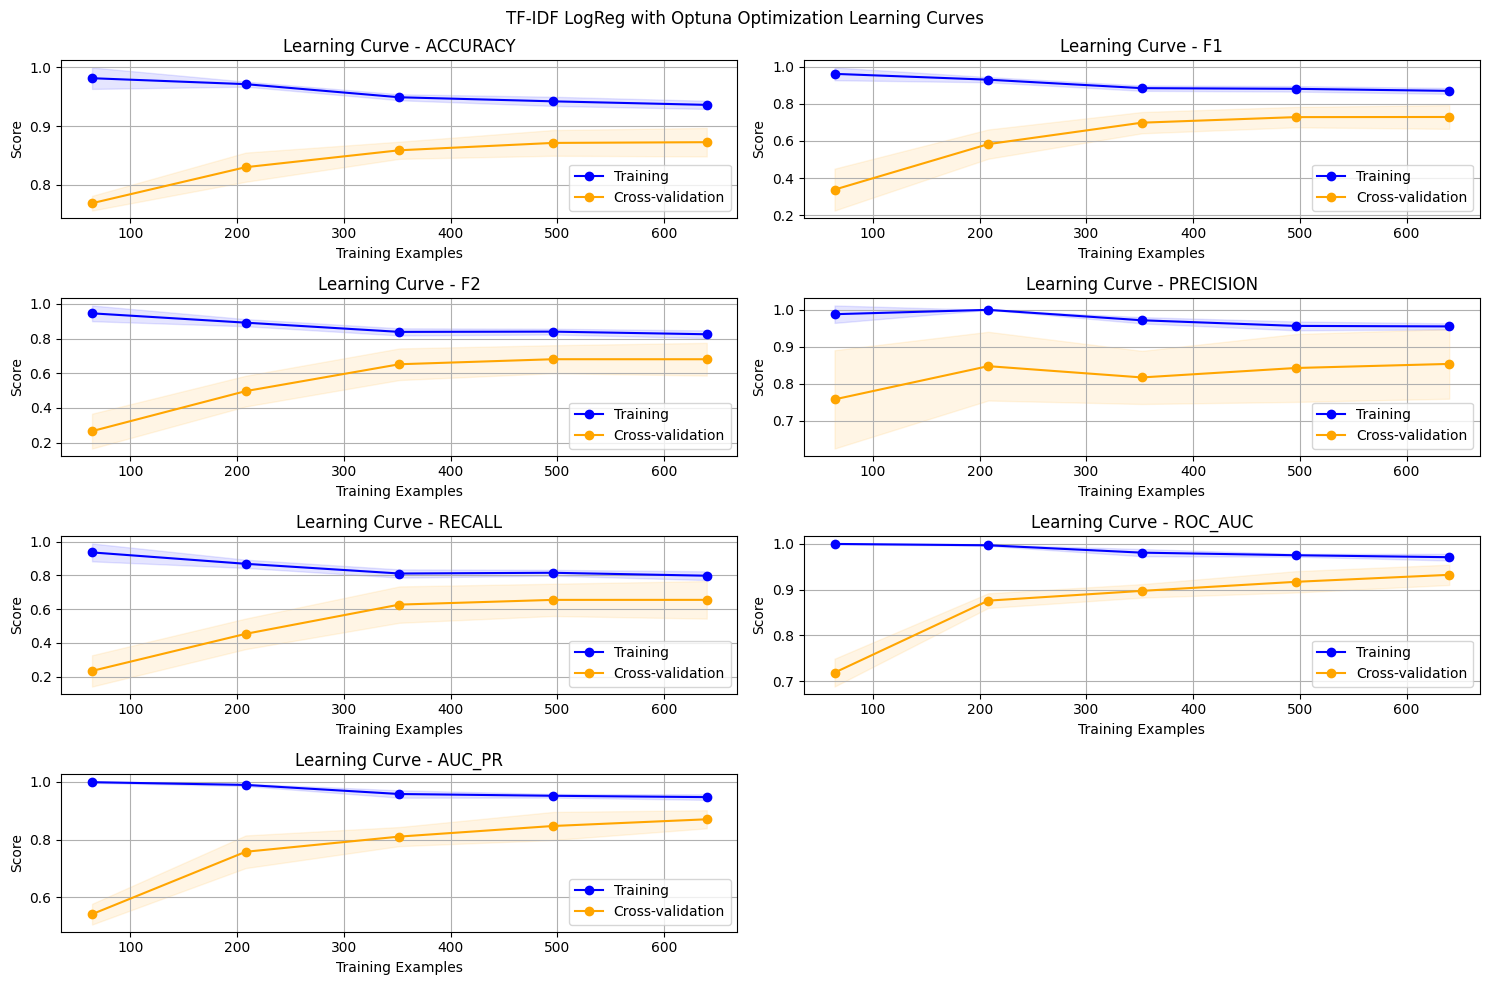


Final Threshold: 0.17

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       146
           1       0.68      0.83      0.75        54

    accuracy                           0.85       200
   macro avg       0.81      0.84      0.82       200
weighted avg       0.87      0.85      0.85       200

Additional Metrics:
Accuracy   0.850
F2-score   0.798
AUC-ROC    0.910
AUC-PR     0.818



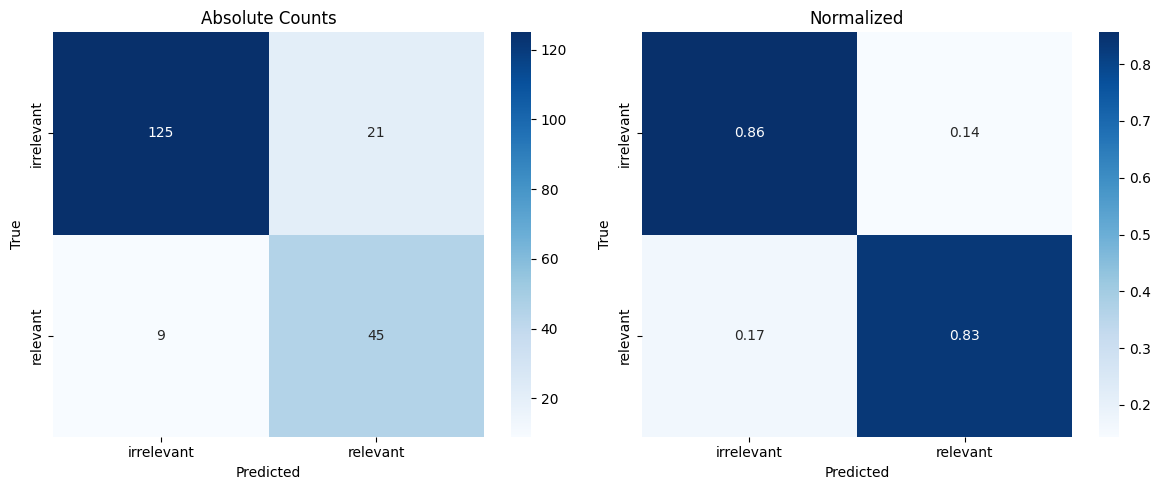

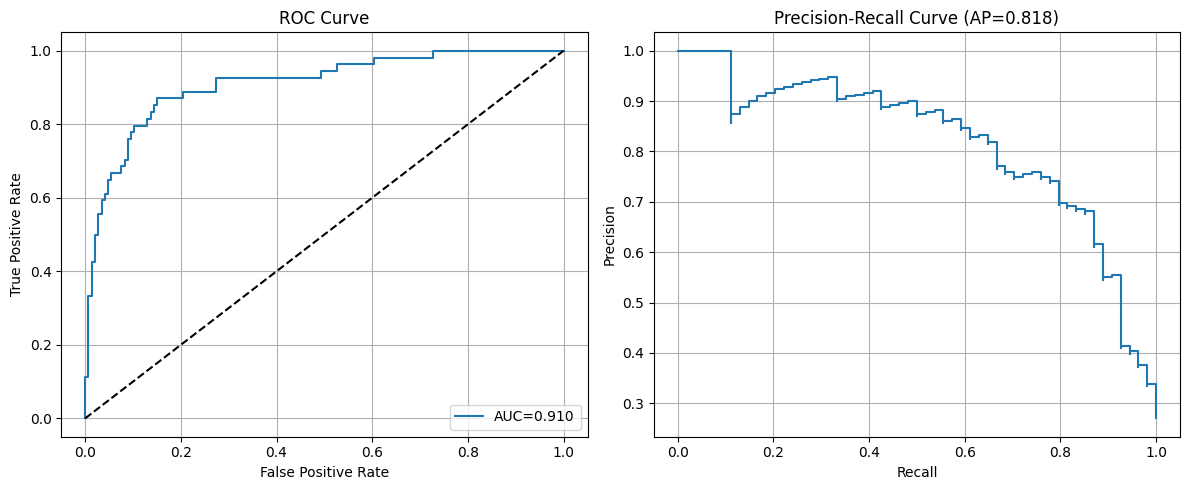


Model saved as 'model_tfidf_logreg_basic.joblib'


In [3]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Pipeline 
pipeline_tfidf_logreg = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     LogisticRegression(
                    solver="liblinear",
                    penalty="l1",
                    random_state=42
                ))
]) 

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 1, 1000),
    "clf__class_weight": lambda trial: sample_class_weight_value(trial, low=1, high=100),
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_logreg,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=500,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_logreg_basic"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LogReg with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + LogReg (Basic Preprocessing)',
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_logreg_basic.joblib")

print(f"\nModel saved as 'model_tfidf_logreg_basic.joblib'")

**Some experimental visualizations**

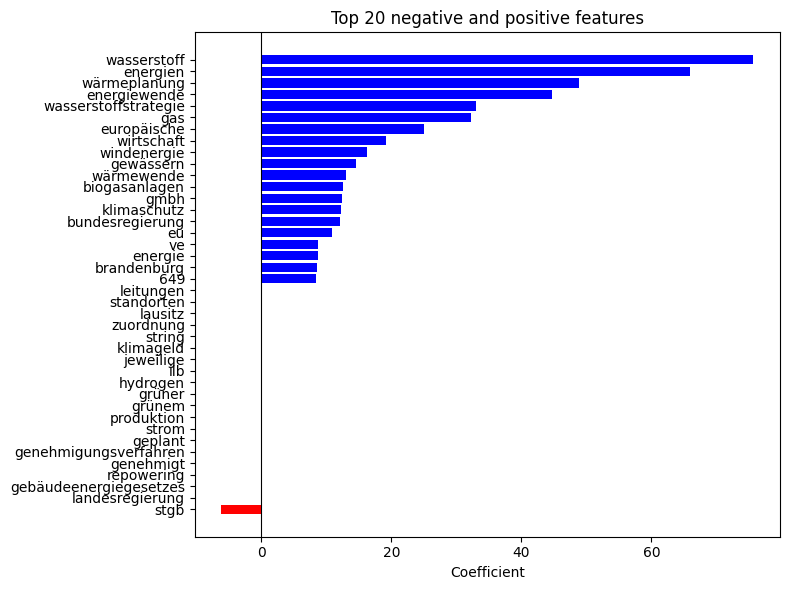

In [9]:
from joblib import load

# load model
data = load("model_tfidf_logreg_basic.joblib")
model      = data['model']
threshold  = data['threshold']
cv_score   = data['cv_score']
best_params= data['best_params']

# plot coefficients
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Access the underlying pipeline through .estimator_ (since model is TunedThresholdClassifierCV)
pipeline = model.estimator_
tfidf  = pipeline.named_steps['tfidf']
select = pipeline.named_steps['select']
clf    = pipeline.named_steps['clf']

all_feats = tfidf.get_feature_names_out()
sel_feats = all_feats[select.get_support()]
coefs     = clf.coef_[0]

df_coef = pd.DataFrame({'feature': sel_feats, 'coef': coefs}).sort_values('coef')
neg20 = df_coef.head(20)
pos20 = df_coef.tail(20)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(neg20['feature'], neg20['coef'], color='red')
ax.barh(pos20['feature'], pos20['coef'], color='blue')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Top 20 negative and positive features')
ax.set_xlabel('Coefficient')
plt.tight_layout()
plt.show()

## 3) TF-IDF + Logistic Regression on advanced preprocessing


First we have to design our advanced preprocessing pipeline and add is as a Module to src `cleaning.py` and `preprocessing.py`. 
- clean more noise (gathered as insights during labeling process)
- remove non alpha characters 
- multiword-grouping (as a improved form of 2-gramming)
- stop word removal
- stemming

**After that, we replicate our steps from section 2) of this notebook on advanced preprocessed data**

**a) We need to train the gensim-phraser on our train-corpus for multiword grouping in the advanced preprocessing pipeline for each k-fold split**

We use the resulting `phrase_transformer.py` module for multiword-grouping (sort of improved 2-gramming) in the model training pipeline. Here we just demonstrate the effect of multiword_grouping. Chosen min_count and treshhold will be tuned during Optuna HPO.

In [5]:
from src.phrase_transformer import PhraseDetector
from src.cleaning import clean_text

# Load raw texts
df_raw = pd.read_csv('../05modeling_pipelines/1klabeled_segments.csv', usecols=['SegmentText'])
#raw_texts = df_raw['SegmentText'].tolist()

# Preprocess in advanced mode
raw_texts_advanced = [clean_text(t, mode='advanced') for t in df_raw['SegmentText']]

# train phraser on whole corpus for demonstrative purposes. in pipeline only on training data
phraser = PhraseDetector(min_count=10, threshold=300.0)
phraser.fit(raw_texts_advanced)

# inspect top phrases
phrasegrams = phraser.phraser_.phrasegrams
records = [{'phrase': p, 'score': s} for p, s in phrasegrams.items()]
df_phrases = pd.DataFrame(records).sort_values('score', ascending=False)

print("Number of learned phrases:", len(df_phrases))
print("\n Top 50 Learned Phrases")
print(df_phrases.head(50))
print("\n Last 50 Phrases")
print(df_phrases.tail(50))

Number of learned phrases: 543

 Top 50 Learned Phrases
                                            phrase        score
245                             offnet_doppelklick  7063.857143
337                                sarah_buddeberg  7026.678947
24                        beratungsdien_referentin  6786.843137
42                                  monika_hohmann  6756.732919
494                               chirurg_orthopad  6671.420635
400                                 hansjurg_zickl  6592.933333
23                  gesetzgebungsund_beratungsdien  6544.455882
65                                    susann_schap  6357.471429
457  hauptverwaltungsbeamtin_hauptverwaltungsbeamt  6245.936842
383                                  claudia_maich  6180.875000
397                             antonia_mertsching  5983.502521
255                                annemari_keding  5951.953704
222                            gunnar_schellenberg  5902.842561
17                         landtagsgebaud_dompla

**b) replicating modeling steps on advanced preprocessing pipeline**

In [6]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

# Calculate token lengths for each segment
df_advancedcleaned['SegmentTokenLength'] = df_advancedcleaned['SegmentText'].str.split().str.len()

# Print overall statistics for token lengths
print("Overall SegmentTokenLength stats:\n", df_advancedcleaned["SegmentTokenLength"].describe())

# Print statistics for token lengths grouped by parliament
print("\nBy Parliament:\n", df_advancedcleaned.groupby("Parliament")["SegmentTokenLength"].describe())
df_advancedcleaned.tail()

Overall SegmentTokenLength stats:
 count    1000.000000
mean      404.891000
std       180.956963
min        11.000000
25%       255.000000
50%       472.000000
75%       538.000000
max       972.000000
Name: SegmentTokenLength, dtype: float64

By Parliament:
             count        mean         std   min     25%    50%     75%    max
Parliament                                                                   
BB          216.0  435.300926  160.543343  25.0  398.50  494.0  536.25  771.0
MV           85.0  422.976471  153.504302  86.0  345.00  470.0  514.00  972.0
SA          268.0  449.194030  178.530518  32.0  338.75  495.5  550.25  951.0
SN          275.0  337.054545  197.048812  19.0  138.00  343.0  531.50  708.0
TH          156.0  396.403846  160.895229  11.0  258.50  457.0  526.50  694.0


,DocumentID,SegmentID,Date,Parliament,Description,Links,Filter,SegmentText,Label,SegmentTokenLength
995,SA_107,SA_107_1,09.08.2023,SA,"Nah- und FernwÃ¤rmenetze in Sachsen-Anhalt, Kl...",[{'url': 'https://padoka.landtag.sachsen-anhal...,"['erdgas', 'wasserstoff', 'biogas', 'biomethan...",dokument gemeind sachsenanhalt gibt nahund fer...,1,571
996,MV_571,MV_571_1,14.04.2025,MV,Gesetz über die Feststellung eines Nachtrags z...,[{'url': 'https://www.dokumentation.landtag-mv...,"['kommunale haushalte', 'energiepreis']",mecklenburgvorpomm beschlussempfehl finanzauss...,1,345
997,SA_639,SA_639_8,20.11.2024,SA,Plenarprotokoll 8/77 20.11.2024 S. 1-190,[{'url': 'https://padoka.landtag.sachsen-anhal...,"['wasserstoff', 'lng', 'kraftwerke', 'wittenbe...",cdu zuruf afd lieb afd ja schwarzgelb jahr sch...,0,499
998,SN_1595,SN_1595_1,01.04.2025,SN,"Krankenhausförderung im Freistaat Sachsen, Pau...",[{'url': 'https://edas.landtag.sachsen.de/reda...,"['wärmeplanung', 'haushaltssicherung']",klanfr franziska schubert bundnisgrun drs sach...,0,562
999,SN_487,SN_487_1,02.01.2024,SN,"""Gefährliche Orte, ""Kontrollstellen"", ""Kontrol...",[{'url': 'https://edas.landtag.sachsen.de/reda...,['heitmüller'],klanfr julian nagel link drs sachsisch klein a...,0,159


**some statistics to gain insights on advanced preprocessed data/influence of advanced preprocessing**

In [7]:
# Simple corpus statistics from segmented data
from collections import Counter
import re

# Extract all tokens from segmented texts
all_tokens = []
for text in df_advancedcleaned['SegmentText']:
    # Remove non-alphabetic characters (keep German umlauts)
    cleaned = re.sub(r"[^a-zäöüß\s]+", " ", text)
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    # Tokenize (whitespace) and filter tokens with more than 1 character
    tokens = [t for t in cleaned.split() if len(t) > 1]
    all_tokens.extend(tokens)

# Count term frequencies
term_freq = Counter(all_tokens)

# Basic statistics
total_docs = len(df_advancedcleaned)
total_tokens = len(all_tokens)
vocab_size = len(term_freq)

print(f"Documents: {total_docs}")
print(f"Total tokens: {total_tokens}")
print(f"Vocabulary size (Unique tokens): {vocab_size}")
print(f"Avg tokens per document: {total_tokens/total_docs:.1f}")

# Create frequency dataframe
df_advancedcleaned_termfreq = pd.DataFrame([
    {'term': term, 'frequency': freq}
    for term, freq in term_freq.items()
]).sort_values('frequency', ascending=False).reset_index(drop=True)

# Show top 30 most frequent terms
print("\nTop 30 frequent terms:")
print(df_advancedcleaned_termfreq.head(30))

# Show top 30 least frequent terms
print("\nTop 30 least frequent terms:")
print(df_advancedcleaned_termfreq.tail(30))





Documents: 1000
Total tokens: 404891
Vocabulary size (Unique tokens): 41753
Avg tokens per document: 404.9

Top 30 frequent terms:
             term  frequency
0            jahr       2242
1            frag       2204
2            wurd       1897
3            stgb       1708
4            land       1708
5              ja       1679
6    landesregier       1618
7           stadt       1520
8            sowi       1416
9     brandenburg       1320
10           bitt       1214
11            afd       1151
12           herr       1088
13        thuring       1080
14            sei       1071
15      sachsisch       1062
16     abgeordnet       1031
17  sachsenanhalt       1025
18           prev       1009
19         antrag       1000
20       massnahm        997
21         offent        986
22           nein        969
23      landkreis        968
24        antwort        962
25          sachs        951
26             pi        924
27           viel        916
28           link        901

**perform train-test split**

In [8]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

**train and evaluate model on advanced preprocessed data**

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 7.158503076638779, 'select__k': 125, 'positive_class_weight': 13, 'phrases__enable': True, 'phrases__min_count': 52, 'phrases__threshold': 8.9484585954377}
Best F2 score during optimization: 0.883

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


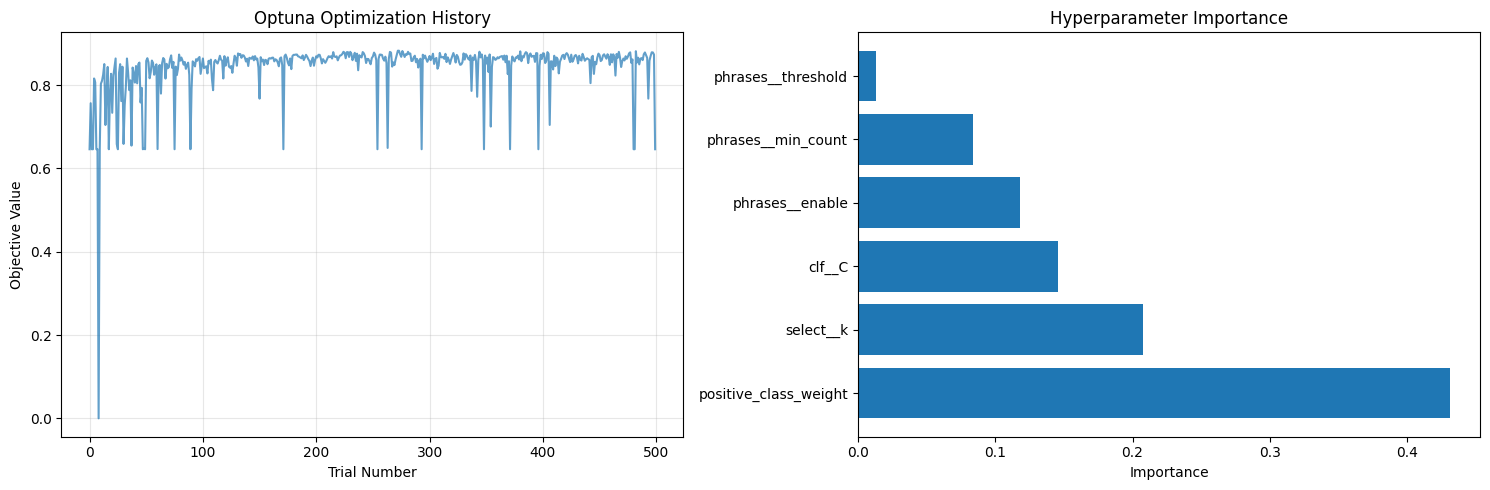


2. Parameter Value Distributions:


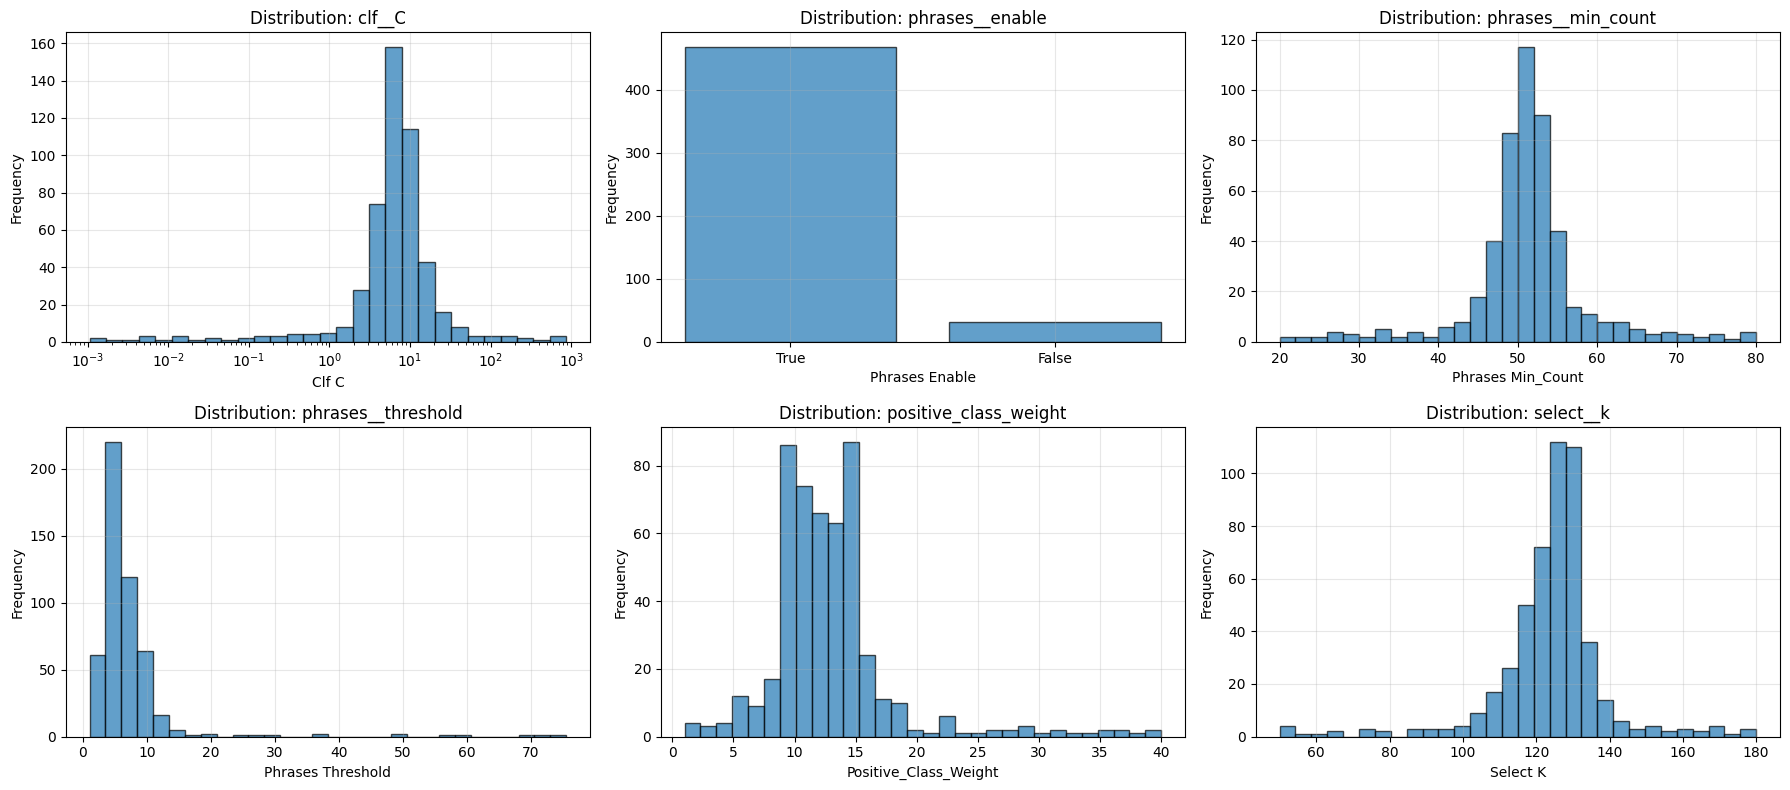


3. Performance vs Individual Parameters:


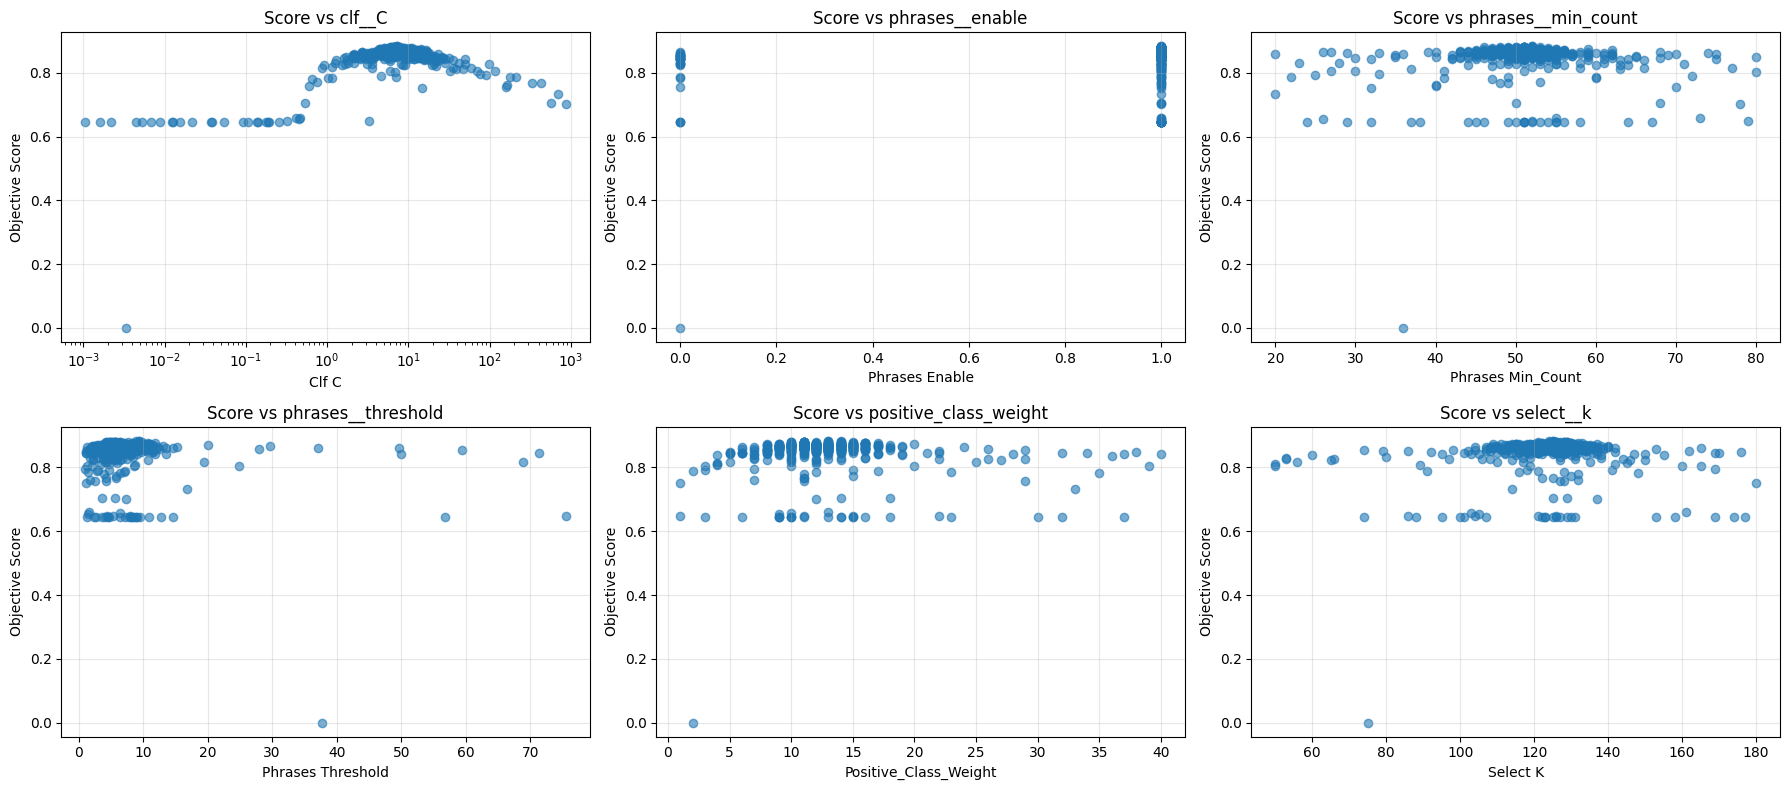


4. Convergence Analysis:


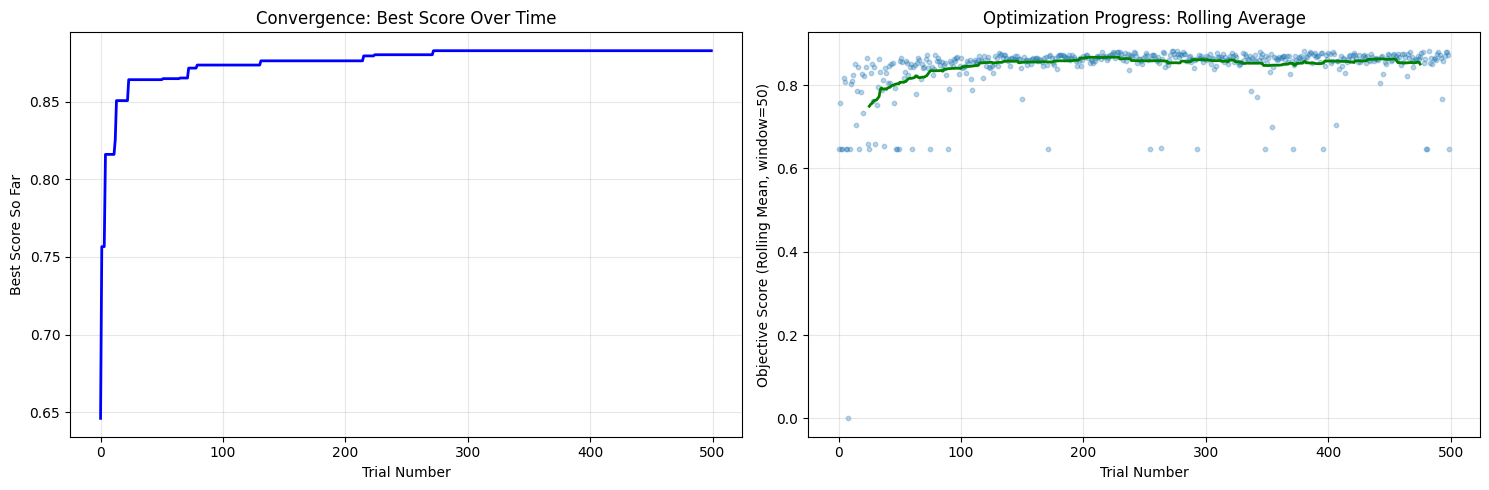


5. Trial Status Overview:


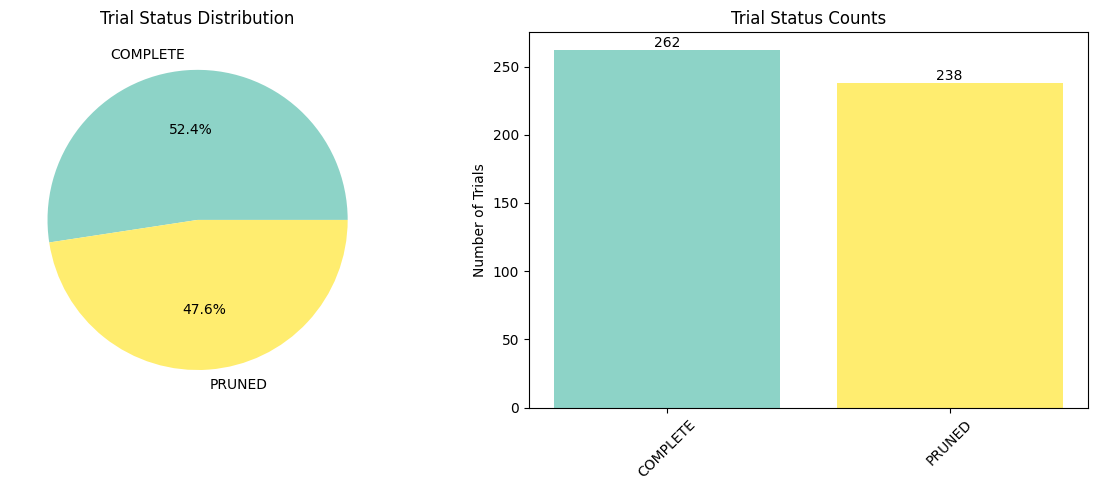


6. Top 10 Best Trials:
Rank Trial#  Score      C            enable       min_count    threshold    positive_class_weight k           
--------------------------------------------------------------------------------------------------------------
1    272     0.8827     7.1585       True         52           8.9485       13           125         
2    273     0.8827     7.2100       True         52           9.4016       13           125         
3    276     0.8819     7.4575       True         52           9.3549       14           124         
4    482     0.8815     6.4269       True         48           9.8424       11           126         
5    380     0.8811     7.1732       True         50           5.1058       14           125         
6    344     0.8802     7.0631       True         49           7.6787       14           127         
7    224     0.8801     7.8789       True         51           4.8925       11           129         
8    281     0.8800     7.1001       Tru

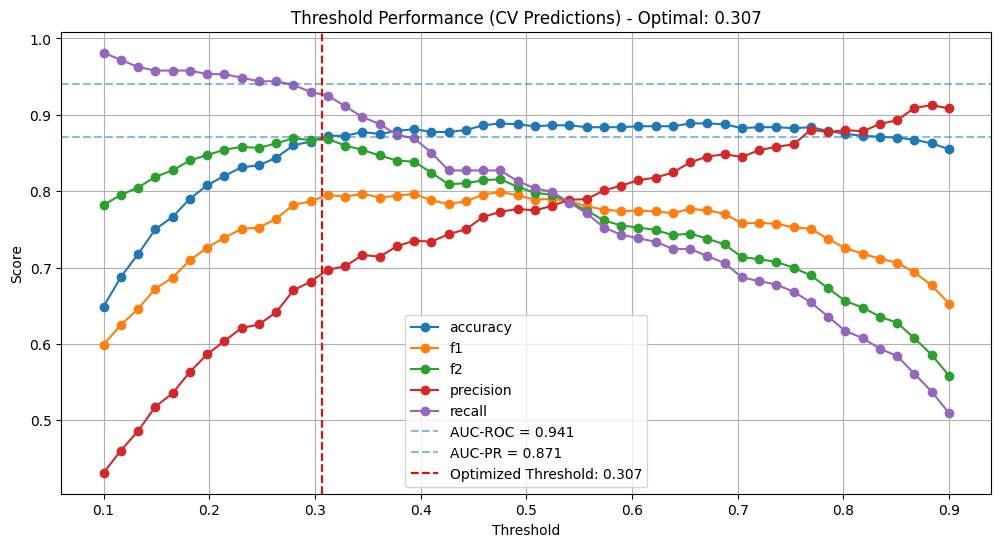

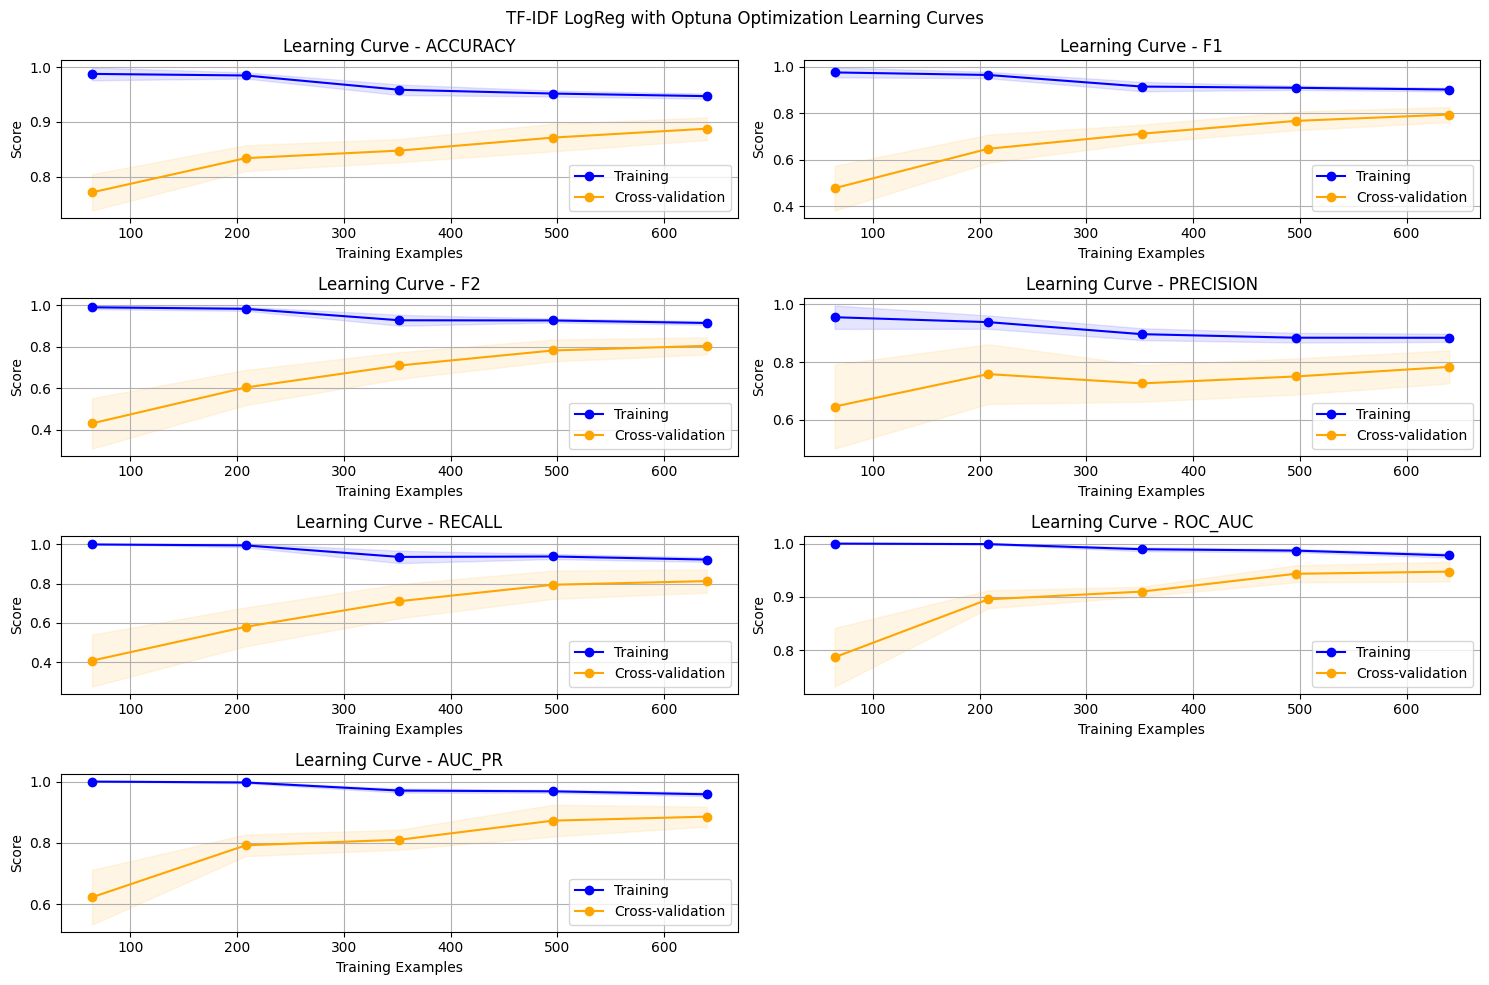


Final Threshold: 0.31

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       146
           1       0.61      0.83      0.70        54

    accuracy                           0.81       200
   macro avg       0.77      0.82      0.78       200
weighted avg       0.84      0.81      0.82       200

Additional Metrics:
Accuracy   0.810
F2-score   0.776
AUC-ROC    0.914
AUC-PR     0.799



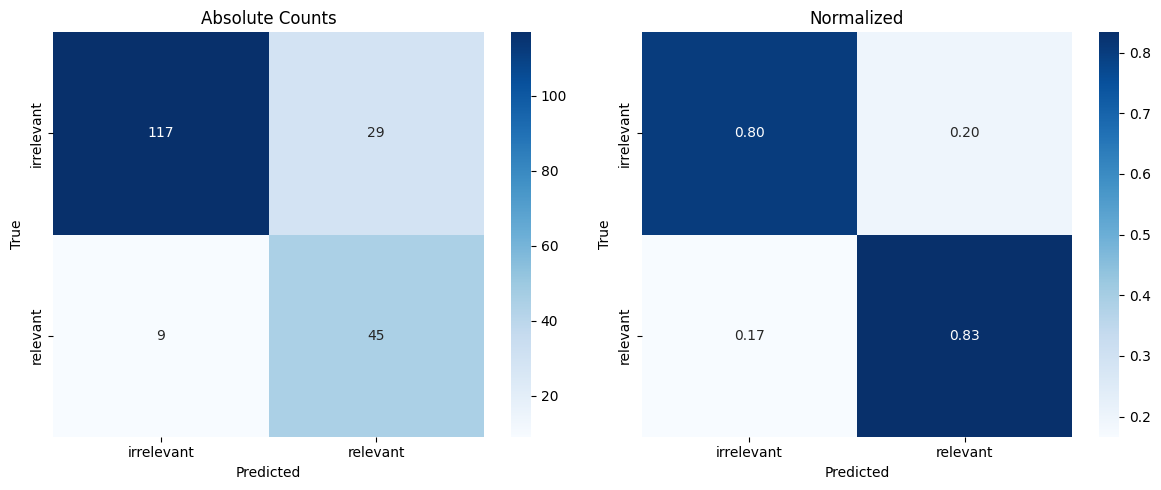

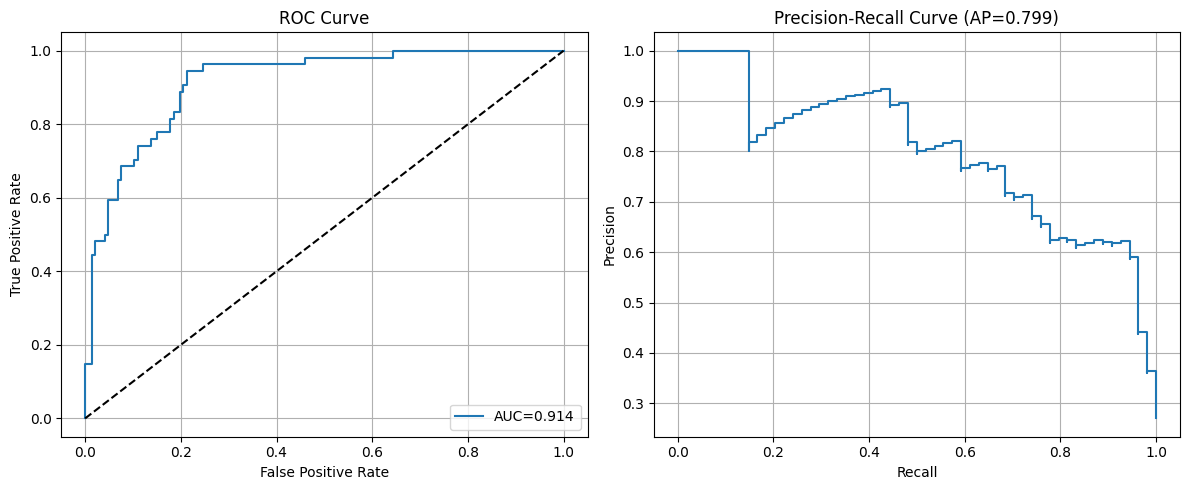


Model saved as 'model_tfidf_logreg_advanced.joblib'


In [17]:
# Base Pipeline 
# Note: standard tfidf vectorization value for token_pattern='(?u)\\b\\w\\w+\\b' includes '_' as part of token
# so that multiword_groups are not split into single words (advanced preprocessing)
# we integrate multiword_grouping into Pipeline structure
pipeline_tfidf_logreg = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True)), 
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LogisticRegression(
                    solver="liblinear",
                    penalty="l1",
                    class_weight="balanced",
                    random_state=42
                ))
])

# CV Strategy, stratified 5-fold cross-validation to maintain label distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range, from optuma_optimizer import sample_class_weight_value
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 180),
    "clf__class_weight": lambda trial: sample_class_weight_value(trial, low=1, high=40),
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [True, False]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 20, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 80.0, log=True)
}


# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_logreg,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=500,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_logreg_advanced"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LogReg with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + LogReg (Advanced Preprocessing)',
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'],
        'test_performance_metrics': test_metrics,  # Complete test performance using modular approach
        'formatted_report': test_report_str  # Human-readable report from extended_classification_report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_logreg_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_logreg_advanced.joblib'")

**experimental visualizations and test if joblib.load works**



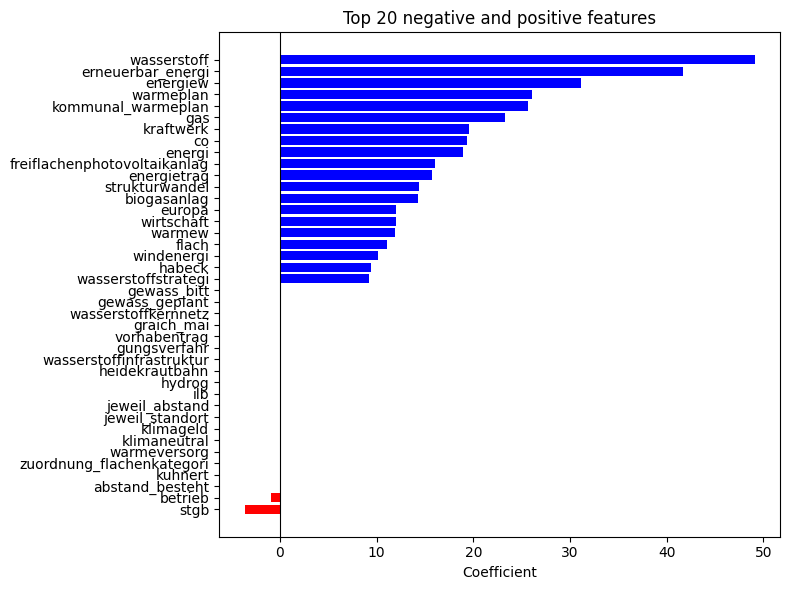

In [12]:
from joblib import load

# load model
data = load("model_tfidf_logreg_advanced.joblib")
model      = data['model']
threshold  = data['threshold']
cv_score   = data['cv_score']
best_params= data['best_params']

# plot coefficients
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Access the underlying pipeline through .estimator_ (since model is TunedThresholdClassifierCV)
pipeline = model.estimator_
tfidf  = pipeline.named_steps['tfidf']
select = pipeline.named_steps['select']
clf    = pipeline.named_steps['clf']

all_feats = tfidf.get_feature_names_out()
sel_feats = all_feats[select.get_support()]
coefs     = clf.coef_[0]

df_coef = pd.DataFrame({'feature': sel_feats, 'coef': coefs}).sort_values('coef')
neg20 = df_coef.head(20)
pos20 = df_coef.tail(20)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(neg20['feature'], neg20['coef'], color='red')
ax.barh(pos20['feature'], pos20['coef'], color='blue')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Top 20 negative and positive features')
ax.set_xlabel('Coefficient')
plt.tight_layout()
plt.show()